<a href="https://colab.research.google.com/github/redaxe101/MastersThesisNotebook/blob/main/Thesis25Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research Notebook: Deep Learning vs. NEM Forecast Spot Prices

## Mark Sinclair, University of New England, 2025

### Version 25

20/9/2025 - Final Model


### Special Bare Version

11/9/2025 - Miminal features

12/9/2025 - Modified positional encoding a little. reduced gaussian noise.

### Version 24

9/9/2025 - quick attempt to improve on result

11/9/2025 - good result, saving

### Version 23

4/9/2025 - Added L2 regularization. Added noise to oversampling.

5/9/2025 - Started with cross-validation implementation

7/9/2025 - completed walk-forward CV implementation

8/9/2025 - a reasonable result. saved

### Version 22

24/8/2025 - try adding LAST_RRP to decoder inputs

25/8/2025 - re-added features. good performance.

27/8/2025 - discovered that the encoder had been disabled by accident for quite some time (thanks to Andreas for finding it)

28/8/2025 - removed many excessive features, used quantile scaler for decoder, dropped back to medium model, fixed LSTM training issue

### Version 21

11/8/2025 - reworked scaling (it took a few days)

15/8/2025 - training sequence visualisation check added

16/8/2025 - added sMAPE and LSTM to evaluation framework

19/8/2025 - completed framework

21/8/2025 - tidied up features (removed repetition). Having problems with encoder features not seeming to matter.

23/8/2025 - Major feature engineering. removed duplication between encoder and decoder.

### Version 20
8/8/2025 - Good results but the dataset is pre-shuffled before splitting - Bad

9/8/2025 - Resumed with pre-shuffling removed. Discovered a big price event in
June that is causing a bit of havoc with the test set results. Added fixed horizon MAE measurement so that overlapping sequences don't unfairly amplify errors.

10/8/2025 - Added July NEM data. Restructured measurements. Added demand prediction and actuals to charts. Dropped some dropout layers.

### Version 19
6/8/2025 - Validating to make sure data isn't leaking

### Version 18
6/8/2025 - A big improvement. Saving the model.

### Version 17
1/8/2025 - Moving towards a baseline model

3/8/2025 - Working well. Revised spike definition to $5000+. Re-coded MAE calcs.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import random
import keras
import sys
import time
import joblib
from keras import layers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.base import clone

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# use mixed precision for faster training
keras.mixed_precision.set_global_policy("mixed_float16")

from google.colab import drive
drive.mount('/content/drive')
import os
os.makedirs("/content/drive/MyDrive/rrp_forecasting", exist_ok=True)

# switch on determinism
tf.config.experimental.enable_op_determinism()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)  # Automatically fit the display
pd.set_option('display.expand_frame_repr', False)

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow version: 2.19.0
Keras version: 3.10.0


  I	PREDISPATCH	REGION_SOLUTION	8	PREDISPATCHSEQNO	RUNNO	REGIONID	PERIODID	INTERVENTION	TOTALDEMAND	AVAILABLEGENERATION	AVAILABLELOAD	DEMANDFORECAST	DISPATCHABLEGENERATION	DISPATCHABLELOAD	NETINTERCHANGE	EXCESSGENERATION	LOWER5MINDISPATCH	LOWER5MINIMPORT	LOWER5MINLOCALDISPATCH	LOWER5MINLOCALPRICE	LOWER5MINLOCALREQ	LOWER5MINPRICE	LOWER5MINREQ	LOWER5MINSUPPLYPRICE	LOWER60SECDISPATCH	LOWER60SECIMPORT	LOWER60SECLOCALDISPATCH	LOWER60SECLOCALPRICE	LOWER60SECLOCALREQ	LOWER60SECPRICE	LOWER60SECREQ	LOWER60SECSUPPLYPRICE	LOWER6SECDISPATCH	LOWER6SECIMPORT	LOWER6SECLOCALDISPATCH	LOWER6SECLOCALPRICE	LOWER6SECLOCALREQ	LOWER6SECPRICE	LOWER6SECREQ	LOWER6SECSUPPLYPRICE	RAISE5MINDISPATCH	RAISE5MINIMPORT	RAISE5MINLOCALDISPATCH	RAISE5MINLOCALPRICE	RAISE5MINLOCALREQ	RAISE5MINPRICE	RAISE5MINREQ	RAISE5MINSUPPLYPRICE	RAISE60SECDISPATCH	RAISE60SECIMPORT	RAISE60SECLOCALDISPATCH	RAISE60SECLOCALPRICE	RAISE60SECLOCALREQ	RAISE60SECPRICE	RAISE60SECREQ	RAISE60SECSUPPLYPRICE	RAISE6SECDISPATCH	RAISE6SECIMPORT	RAISE6SECLOCALDISPATCH	RAISE6SECLOCALPRICE	RAISE6SECLOCALREQ	RAISE6SECPRICE	RAISE6SECREQ	RAISE6SECSUPPLYPRICE	LASTCHANGED	DATETIME	INITIALSUPPLY	CLEAREDSUPPLY	LOWERREGIMPORT	LOWERREGLOCALDISPATCH	LOWERREGLOCALREQ	LOWERREGREQ	RAISEREGIMPORT	RAISEREGLOCALDISPATCH	RAISEREGLOCALREQ	RAISEREGREQ	RAISE5MINLOCALVIOLATION	RAISEREGLOCALVIOLATION	RAISE60SECLOCALVIOLATION	RAISE6SECLOCALVIOLATION	LOWER5MINLOCALVIOLATION	LOWERREGLOCALVIOLATION	LOWER60SECLOCALVIOLATION	LOWER6SECLOCALVIOLATION	RAISE5MINVIOLATION	RAISEREGVIOLATION	RAISE60SECVIOLATION	RAISE6SECVIOLATION	LOWER5MINVIOLATION	LOWERREGVIOLATION	LOWER60SECVIOLATION	LOWER6SECVIOLATION	RAISE6SECACTUALAVAILABILITY	RAISE60SECACTUALAVAILABILITY	RAISE5MINACTUALAVAILABILITY	RAISEREGACTUALAVAILABILITY	LOWER6SECACTUALAVAILABILITY	LOWER60SECACTUALAVAILABILITY	LOWER5MINACTUALAVAILABILITY	LOWERREGACTUALAVAILABILITY	DECAVAILABILITY	LORSURPLUS	LRCSURPLUS	TOTALINTERMITTENTGENERATION	DEMAND_AND_NONSCHEDGEN	UIGF	SEMISCHEDULE_CLEAREDMW	SEMISCHEDULE_COMPLIANCEMW	SS_SOLAR_UIGF	SS_WIND_UIGF	SS_SOLAR_CLEAREDMW	SS_WIND_CLEAREDMW	SS_SOLAR_COMPLIANCEMW	SS_WIND_COMPLIANCEMW	WDR_INITIALMW	WDR_AVAILABLE	WDR_DISPATCHED	LOWER1SECLOCALDISPATCH	RAISE1SECLOCALDISPATCH	RAISE1SECACTUALAVAILABILITY	LOWER1SECACTUALAVAILABILITY	SS_SOLAR_AVAILABILITY	SS_WIND_AVAILABILITY	BDU_ENERGY_STORAGE	BDU_MIN_AVAIL	BDU_MAX_AVAIL	BDU_CLEAREDMW_GEN	BDU_CLEAREDMW_LOAD	RUN_DATETIME


  I,PREDISPATCH,REGION_PRICES,2,PREDISPATCHSEQNO,RUNNO,REGIONID,PERIODID,INTERVENTION,RRP,EEP,RRP1,EEP1,RRP2,EEP2,RRP3,EEP3,RRP4,EEP4,RRP5,EEP5,RRP6,EEP6,RRP7,EEP7,RRP8,EEP8,LASTCHANGED,DATETIME,RAISE6SECRRP,RAISE60SECRRP,RAISE5MINRRP,RAISEREGRRP,LOWER6SECRRP,LOWER60SECRRP,LOWER5MINRRP,LOWERREGRRP,RAISE1SECRRP,LOWER1SECRRP


In [ ]:
decoder_feature_cols = [
    # "F_RAISE6SECRRP","F_RAISE60SECRRP","F_RAISE5MINRRP","F_RAISEREGRRP","F_LOWER6SECRRP","F_LOWER60SECRRP","F_LOWER5MINRRP","F_LOWERREGRRP","F_RAISE1SECRRP","F_LOWER1SECRRP",
    # "F_NETINTERCHANGE",
    # "F_TOTALINTERMITTENTGENERATION",
    # "F_DEMAND_AND_NONSCHEDGEN",
    # "F_INITIALSUPPLY",
    # "F_CLEAREDSUPPLY",
    # "F_UIGF",
    # "F_SS_SOLAR_UIGF",
    # "F_SS_WIND_UIGF",
    # "F_SS_SOLAR_CLEAREDMW",
    # "F_SS_SOLAR_CLEAREDMW_NSW1",
    # "F_SS_SOLAR_CLEAREDMW_VIC1",
    # "F_SS_SOLAR_CLEAREDMW_QLD1",
    # "F_SS_SOLAR_CLEAREDMW_TAS1",
    # "F_SS_SOLAR_CLEAREDMW_SA1",
    # "F_SS_WIND_CLEAREDMW",
    # "F_SS_SOLAR_COMPLIANCEMW",
    # "F_SS_WIND_COMPLIANCEMW",
    # "F_BDU_CLEAREDMW_GEN",
    # "F_BDU_CLEAREDMW_LOAD",

    # "F_AVAILABLEGENERATION_NSW1",
    # "F_RESERVE_MARGIN_NSW1",
    # "F_RENEWABLES_SHARE_NSW1",
    # "F_IMPORT_RATIO_NSW1",
    # "F_AVAILABLEGENERATION_VIC1",
    # "F_RESERVE_MARGIN_VIC1",
    # "F_RENEWABLES_SHARE_VIC1",
    # "F_IMPORT_RATIO_VIC1",
    # "F_AVAILABLEGENERATION_QLD1",
    # "F_RESERVE_MARGIN_QLD1",
    # "F_RENEWABLES_SHARE_QLD1",
    # "F_IMPORT_RATIO_QLD1",
    # "F_RESERVE_MARGIN_SA1",
    # "F_RENEWABLES_SHARE_SA1",
    # "F_IMPORT_RATIO_SA1",
    # "F_RESERVE_MARGIN_TAS1",
    # "F_RENEWABLES_SHARE_TAS1",
    # "F_IMPORT_RATIO_TAS1",

    # "F_rrp_yesterday",
    # "F_rrp_rolling_std", "F_rrp_max_past", "F_rrp_max_past_day",
    # "F_rrp_pct_change",
    # "F_rrp_abs_change",
    # "F_rrp_range",
    # "F_rrp_rolling_quantile_90",
    # "F_rrp_above_q90",
    # "F_demand_rolling_quantile_90",
    # "F_demand_above_q90",
    # "F_rrp_skew",
    # "F_rrp_kurt",
    # "F_rrp_ma_12",
    # "F_rrp_mean_24",
    # "F_rrp_std_24",
    "F_RRP_NSW1",
    "F_RRP_VIC1",
    "F_RRP_QLD1",
    "F_RRP_SA1",
    "F_RRP_TAS1",

    "F_TOTALDEMAND_NSW1",
    "F_TOTALDEMAND_VIC1",
    "F_TOTALDEMAND_QLD1",
    "F_TOTALDEMAND_SA1",
    "F_TOTALDEMAND_TAS1",

    "F_rrp_min_past_NSW1",
    "F_rrp_min_past_VIC1",
    "F_rrp_min_past_QLD1",

    "F_rrp_zscore_NSW1",
    "F_rrp_zscore_QLD1",
    "F_rrp_zscore_VIC1",
    "F_rrp_zscore_TAS1",
    "F_rrp_zscore_SA1",

    "F_half_hour_sin",
    "F_half_hour_cos",
    "F_hours_to_delivery",

    "F_TEMPHUMIDITY",
    "F_TEMP_ABOVE",
    "F_TEMP_BELOW",

    "F_rrp_to_demand_NSW1",
    "F_rrp_to_demand_QLD1",
    "F_rrp_to_demand_VIC1",

    # "LAST_RRP",
]

encoder_feature_cols = [
    # "TOTALDEMAND_NSW1",
    # "TOTALDEMAND_VIC1",
    # "TOTALDEMAND_QLD1",
    # "TOTALDEMAND_TAS1",
    # "TOTALDEMAND_SA1",
    # "half_hour_sin", "half_hour_cos",
    # "dow_sin", "dow_cos",
    # "month_sin", "month_cos",
    # "workday",

    # "temperature_2m",
    # "cloudcover",
    # "relative_humidity_2m", "windspeed_10m",
    # "rrp_to_demand_SA1",
    # "rrp_to_demand_TAS1",
    # "rrp_yesterday",
    # "rrp_rolling_std",
    "RRP_NSW1",
    "RRP_VIC1",
    "RRP_QLD1",
    "RRP_TAS1",
    "RRP_SA1",

    "TEMPHUMIDITY",
    "TEMP_ABOVE",
    "TEMP_BELOW",

    "rrp_to_demand_NSW1",
    "rrp_to_demand_VIC1",
    "rrp_to_demand_QLD1",
    "rrp_max_past_NSW1",
    "rrp_max_past_VIC1",
    "rrp_max_past_QLD1",
    "rrp_skew_NSW1",
    "rrp_skew_QLD1",
    "rrp_skew_VIC1",
    "rrp_kurt_NSW1",
    "rrp_kurt_QLD1",
    "rrp_kurt_VIC1",

    # "rrp_max_past_SA1",
    # "rrp_max_past_TAS1",
    # "rrp_max_past_day",
    # "rrp_pct_change",
    # "rrp_abs_change",
    # "rrp_min_past",
    # "rrp_range",
    # "rrp_rolling_quantile_90",
    # "rrp_above_q90",
    # "demand_rolling_quantile_90",
    # "demand_above_q90",
    # "rrp_ma_12",
    # "rrp_mean_24",
    # "rrp_std_24",
    # "rrp_zscore",
]

region = "NSW1" # can be NSW1, VIC1 or QLD1
output_length = 32 #max 32
input_length = 48
batch_size = 128
SPIKE_THRESHOLD = 5000

# Data Pipeline

In [ ]:
import pandas as pd
import numpy as np
from pandas import IndexSlice as idx
import joblib
from sklearn.preprocessing import RobustScaler, QuantileTransformer
import os
import requests

def fetch_actual_weather(start_date, end_date, region):
    """
    Fetch actual weather data from Open-Meteo API, with local CSV caching.
    """
    cache_path=f"/content/drive/MyDrive/NEM/actual_weather_cache_{region}.csv"
    if os.path.exists(cache_path):
        cache = pd.read_csv(cache_path, parse_dates=["time"])
        cache.set_index("time", inplace=True)
    else:
        cache = pd.DataFrame()

    start_dt = pd.to_datetime(start_date).floor("D")
    end_dt = pd.to_datetime(end_date).ceil("D")

    if not cache.empty:
        cached_range = pd.date_range(cache.index.min(), cache.index.max(), freq="30min")
    else:
        cached_range = pd.DatetimeIndex([])

    full_range = pd.date_range(start=start_dt, end=end_dt, freq="30min")
    missing_times = full_range.difference(cached_range)

    if not missing_times.empty:
        # Fetch the missing full days from Open-Meteo (to avoid partial gaps)
        fetch_start = missing_times.min().strftime("%Y-%m-%d")
        fetch_end = missing_times.max().strftime("%Y-%m-%d")

        print(f"🌤 Fetching missing weather from {fetch_start} to {fetch_end}...")

        match region:
          case "NSW1":
            lat = -33.8148
            lon = 151.0017
          case "QLD1":
            lat = -27.4705
            lon = 153.0251
          case "VIC1":
            lat = -37.8136
            lon = 144.9631
          case "TAS1":
            lat = -42.8829
            lon = 147.3272
          case "SA1":
            lat = -34.9285
            lon = 138.5999

        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": fetch_start,
            "end_date": fetch_end,
            "hourly": "temperature_2m,cloudcover,relative_humidity_2m,windspeed_10m",
            "timezone": "Australia/Brisbane"
        }
        r = requests.get(url, params=params)
        data = r.json()["hourly"]
        new_df = pd.DataFrame(data)
        new_df["time"] = pd.to_datetime(new_df["time"])
        new_df.set_index("time", inplace=True)
        new_df = new_df.resample("30min").interpolate("linear").ffill().bfill()

        cache = pd.concat([cache, new_df]).sort_index().drop_duplicates()
        cache.to_csv(cache_path)
    else:
        print("✅ Loaded weather from cache.")

    return cache[start_dt:end_dt]

def fetch_price_data(start_date, end_date, region):
    path = f"/content/drive/MyDrive/NEM/older_pre_dispatch/output/{region}_prices.csv"
    with open(path, "r") as f:
      header = f.readline().strip().split(",")

    # print(header)
    df = pd.read_csv(path, usecols=header, parse_dates=["DATETIME", "LASTCHANGED"])

    df = df.rename(columns={"LASTCHANGED": "RUN_DATETIME"})
    df.index = df.index.set_names(
        [name if name != "LASTCHANGED" else "RUN_DATETIME"
        for name in df.index.names]
    )

    df["RUN_DATETIME"] = df["RUN_DATETIME"].dt.floor("30min")
    df["DATETIME"] = df["DATETIME"] - pd.Timedelta("30min")
    df = df.dropna(subset=["RUN_DATETIME", "DATETIME"])
    df = df.groupby(["RUN_DATETIME", "DATETIME"]).mean(numeric_only=True)
    df.sort_index(inplace=True)

    return df.loc[start_date:end_date]

def add_time_features(df, region):
    """
    Adds sine and cosine time-based features to a DataFrame with a DatetimeIndex or MultiIndex,
    using 30-minute intervals that are adjusted for daylight savings.

    Features:
        - half_hour_sin, half_hour_cos (48 values/day, DST-adjusted)
        - dow_sin, dow_cos (day of week)
        - month_sin, month_cos (month of year)
    """
    import pandas as pd
    import numpy as np

    if region == "QLD1":
      timezone="Australia/Brisbane"
    else:
      timezone="Australia/Sydney"

    if not isinstance(df.index, (pd.DatetimeIndex, pd.MultiIndex)):
        raise ValueError("df must have a DatetimeIndex or MultiIndex")

    # Extract datetime index (convert to local time with DST handling)
    if isinstance(df.index, pd.MultiIndex):
        datetime_index = df.index.get_level_values("DATETIME")
    else:
        datetime_index = df.index

    # Ensure timezone-aware index
    if datetime_index.tz is None:
        datetime_index = datetime_index.tz_localize("UTC").tz_convert(timezone)
    else:
        datetime_index = datetime_index.tz_convert(timezone)

    # Half hour slot
    half_hour_slot = datetime_index.hour * 2 + (datetime_index.minute // 30)
    df["half_hour_sin"] = np.sin(2 * np.pi * half_hour_slot / 48)
    df["half_hour_cos"] = np.cos(2 * np.pi * half_hour_slot / 48)

    # Day of week
    df["dow_sin"] = np.sin(2 * np.pi * datetime_index.dayofweek / 7)
    df["dow_cos"] = np.cos(2 * np.pi * datetime_index.dayofweek / 7)
    df["workday"] = (datetime_index.dayofweek <= 4).astype(int)

    # Month of year
    df["month_sin"] = np.sin(2 * np.pi * datetime_index.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * datetime_index.month / 12)

    return df

def fetch_predispatch_data(start_date, end_date, region, output_length, primary=True):
    path = f"/content/drive/MyDrive/NEM/older_pre_dispatch/output/{region}_pre_dispatch.csv"
    with open(path, "r") as f:
      header = f.readline().strip().split(",")

    print(f" -{region}")

    df = pd.read_csv(path, usecols=header, parse_dates=["DATETIME", "LASTCHANGED"])

    df = df.rename(columns={"LASTCHANGED": "RUN_DATETIME"})
    df.index = df.index.set_names(
        [name if name != "LASTCHANGED" else "RUN_DATETIME"
        for name in df.index.names]
    )

    df["RUN_DATETIME"] = df["RUN_DATETIME"].dt.floor("30min")
    df["DATETIME"] = df["DATETIME"] - pd.Timedelta("30min")
    df = df.dropna(subset=["RUN_DATETIME", "DATETIME"])

    df = df.groupby(["RUN_DATETIME", "DATETIME"]).mean(numeric_only=True)
    df.sort_index(inplace=True)
    df = df.reset_index()

    df["RESERVE_MARGIN"] = df["AVAILABLEGENERATION"] - df["TOTALDEMAND"]
    df["RENEWABLES_SHARE"] = df["TOTALINTERMITTENTGENERATION"] / df["AVAILABLEGENERATION"]
    df["IMPORT_RATIO"] = df["NETINTERCHANGE"] / df["TOTALDEMAND"]
    df["hours_to_delivery"] = (df["DATETIME"] - df["RUN_DATETIME"]).dt.total_seconds() / 3600

    df = df.groupby("RUN_DATETIME").head(output_length)
    df.set_index(["RUN_DATETIME", "DATETIME"], inplace=True)

    df_prices = fetch_price_data(start_date, end_date, region)
    df = df.merge(df_prices, how='left', left_index=True, right_index=True)

    df["rrp_yesterday"] = df["RRP"].shift(48)
    df["rrp_rolling_std"] = df["RRP"].rolling(4).std().fillna(0)
    df["rrp_max_past"] = df["RRP"].rolling(4).max().fillna(0)
    df["rrp_max_past_day"] = df["RRP"].rolling(48).max().fillna(0)
    df["rrp_pct_change"] = df["RRP"].pct_change(fill_method=None).fillna(0).clip(lower=-1000, upper=1000)
    df["rrp_abs_change"] = df["RRP"].diff().abs().fillna(0)
    df["rrp_min_past"] = df["RRP"].rolling(4).min().fillna(0)
    df["rrp_range"] = df["rrp_max_past"] - df["rrp_min_past"]
    df["rrp_rolling_quantile_90"] = df["RRP"].rolling(96).quantile(0.9).fillna(0)
    df["rrp_above_q90"] = (df["RRP"] > df["rrp_rolling_quantile_90"]).astype(int)
    df["demand_rolling_quantile_90"] = df["TOTALDEMAND"].rolling(96).quantile(0.9).fillna(0)
    df["demand_above_q90"] = (df["TOTALDEMAND"] > df["demand_rolling_quantile_90"]).astype(int)
    df["rrp_skew"] = df["RRP"].rolling(24).skew().fillna(0)
    df["rrp_kurt"] = df["RRP"].rolling(24).kurt().fillna(0)
    df["rrp_ma_12"] = df["RRP"].rolling(12).mean().fillna(0)
    df["rrp_dev_ma12"] = (df["RRP"] - df["rrp_ma_12"]) / (df["rrp_ma_12"].abs() + 1e-6).clip(lower=0, upper=10)
    window = 24
    df["rrp_mean_24"] = df["RRP"].rolling(window).mean()
    df["rrp_std_24"] = df["RRP"].rolling(window).std()
    df["rrp_zscore"] = (df["RRP"] - df["rrp_mean_24"]) / (df["rrp_std_24"] + 1e-6).clip(lower=-10, upper=10)
    df["rrp_to_demand"] = (df["RRP"] / (df["TOTALDEMAND"] + 1e-6)).clip(lower=-1, upper=1)

    if not primary:
      df = df.add_suffix(f"_{region}")

    return df.loc[start_date:end_date]

def fetech_RRP_actuals(region, primary=True):
    df = pd.DataFrame()
    for month in list(range(202211, 202213)) + list(range(202301, 202313)) + list(range(202401, 202413)) + list(range(202501, 202509)):
        site = f"/content/drive/MyDrive/NEM/FiveMinPrices/PRICE_AND_DEMAND_{month}_{region}.csv"
        # print(site)
        a = pd.read_csv(site, header=0, usecols=[1, 2, 3], parse_dates=[0], index_col=0)
        df = pd.concat([df, a]) if not df.empty else a
    # Shift timestamps 5 minutes earlier to align with start of interval
    df.index = pd.to_datetime(df.index)  # Just in case
    df.index = df.index - pd.Timedelta(minutes=5)
    # Resample to left-labeled 30-minute intervals
    df = df.resample('30min', label='left', closed='left').mean()

    df.index.name = 'timestamp'
    df = df[['RRP', 'TOTALDEMAND']]

    df["rrp_yesterday"] = df["RRP"].shift(48)
    df["rrp_rolling_std"] = df["RRP"].rolling(4).std().fillna(0)
    df["rrp_max_past"] = df["RRP"].rolling(4).max().fillna(0)
    df["rrp_max_past_day"] = df["RRP"].rolling(48).max().fillna(0)

    df["rrp_pct_change"] = df["RRP"].pct_change(fill_method=None).fillna(0).clip(lower=-1000, upper=1000)
    df["rrp_abs_change"] = df["RRP"].diff().abs().fillna(0)
    df["rrp_min_past"] = df["RRP"].rolling(4).min().fillna(0)
    df["rrp_range"] = df["rrp_max_past"] - df["rrp_min_past"]
    df["rrp_rolling_quantile_90"] = df["RRP"].rolling(96).quantile(0.9).fillna(0)
    df["rrp_above_q90"] = (df["RRP"] > df["rrp_rolling_quantile_90"]).astype(int)
    df["demand_rolling_quantile_90"] = df["TOTALDEMAND"].rolling(96).quantile(0.9).fillna(0)
    df["demand_above_q90"] = (df["TOTALDEMAND"] > df["demand_rolling_quantile_90"]).astype(int)
    df["rrp_skew"] = df["RRP"].rolling(24).skew().fillna(0)
    df["rrp_kurt"] = df["RRP"].rolling(24).kurt().fillna(0)
    df["rrp_ma_12"] = df["RRP"].rolling(12).mean().fillna(0)
    df["rrp_dev_ma12"] = (df["RRP"] - df["rrp_ma_12"]) / (df["rrp_ma_12"].abs() + 1e-6).clip(lower=0, upper=10)
    window = 24
    df["rrp_mean_24"] = df["RRP"].rolling(window).mean()
    df["rrp_std_24"] = df["RRP"].rolling(window).std()
    df["rrp_zscore"] = (df["RRP"] - df["rrp_mean_24"]) / (df["rrp_std_24"] + 1e-6).clip(lower=-10, upper=10)
    df["rrp_to_demand"] = (df["RRP"] / (df["TOTALDEMAND"] + 1e-6)).clip(lower=0, upper=1)

    if not primary:
      df = df.add_suffix(f"_{region}")

    return df


def load_and_prepare_data(input_length, output_length, encoder_feature_cols,
                          decoder_feature_cols,
                          cache_file=f"/content/drive/MyDrive/rrp_forecasting/cached_data_bare_i{input_length}_{region}.npz",
                          force_refresh=False, region='NSW1'):

    if not force_refresh and os.path.exists(cache_file):
        print(f"📦 Loading data from cache: {cache_file}")
        data = np.load(cache_file, allow_pickle=True)
        df_actual = pd.read_csv(cache_file.replace(".npz", "_df_actual.csv"), parse_dates=['timestamp'])
        df_actual = df_actual.set_index(["timestamp"])
        df_nem_f = pd.read_csv(cache_file.replace(".npz", "_df_nem_f.csv"), parse_dates=['RUN_DATETIME','DATETIME'])
        df_nem_f = df_nem_f.set_index(["RUN_DATETIME", "DATETIME"])
        return data['X_enc'], data['X_dec'], data['y'], data['y_dem'], df_actual, df_nem_f

    print("🌐 Fetching and processing data from source...")

    df = fetech_RRP_actuals(region)
    df = add_time_features(df, region)

    start_date = df.index.min().isoformat()
    end_date = df.index.max().isoformat()
    # end_date = "2025-07-26T23:30:00"
    print(start_date)
    print(end_date)

    df=df.join(fetech_RRP_actuals("VIC1", primary=False), how='left')
    df=df.join(fetech_RRP_actuals("QLD1", primary=False), how='left')
    df=df.join(fetech_RRP_actuals("NSW1", primary=False), how='left')
    df=df.join(fetech_RRP_actuals("TAS1", primary=False), how='left')
    df=df.join(fetech_RRP_actuals("SA1", primary=False), how='left')

    # === Add actual weather data to df ===
    print("🌤 Fetching actual weather...")
    actual_weather = fetch_actual_weather(start_date, end_date, region)
    actual_weather["TEMP_ABOVE"] = (actual_weather["temperature_2m"] - 27).clip(lower=0)
    actual_weather["TEMP_BELOW"] = (16 - actual_weather["temperature_2m"]).clip(lower=0)
    actual_weather["TEMPHUMIDITY"] = actual_weather["TEMP_ABOVE"] * actual_weather["relative_humidity_2m"]

    df = df.join(actual_weather, how="left").ffill().bfill()

    print("🌤 Fetching forecast NEM data...")
    df_pre = fetch_predispatch_data(start_date, end_date, region, output_length)
    df_pre=df_pre.join(fetch_predispatch_data(start_date, end_date, "VIC1", output_length, primary=False), how='left')
    df_pre=df_pre.join(fetch_predispatch_data(start_date, end_date, "QLD1", output_length, primary=False), how='left')
    df_pre=df_pre.join(fetch_predispatch_data(start_date, end_date, "NSW1", output_length, primary=False), how='left')
    df_pre=df_pre.join(fetch_predispatch_data(start_date, end_date, "SA1", output_length, primary=False), how='left')
    df_pre=df_pre.join(fetch_predispatch_data(start_date, end_date, "TAS1", output_length, primary=False), how='left')

    print("🌤 Fetching forecast weather...")
    forecast_df = pd.read_csv(f"/content/drive/MyDrive/NEM/historical_forecast_cache_{region}.csv", parse_dates=["RUN_DATETIME", "DATETIME"])
    forecast_df = forecast_df.sort_values(["RUN_DATETIME", "DATETIME"])
    forecast_df = forecast_df.set_index(["RUN_DATETIME", "DATETIME"])
    forecast_df["TEMP_ABOVE"] = (forecast_df["temperature_2m"] - 27).clip(lower=0)
    forecast_df["TEMP_BELOW"] = (16 - forecast_df["temperature_2m"]).clip(lower=0)
    forecast_df["TEMPHUMIDITY"] = forecast_df["TEMP_ABOVE"] * forecast_df["relative_humidity_2m"]

    # print(forecast_df.head())
    df_pre = df_pre.merge(forecast_df, how="left", left_index=True, right_index=True)
    df_pre = add_time_features(df_pre, region)
    df_pre = df_pre.add_prefix("F_")
    df_pre["LAST_RRP"] = 0.0

    end_date = min(df.index.get_level_values(0).max(), df_pre.index.get_level_values(0).max()).isoformat()
    df = df.loc[start_date:end_date]
    print(df_pre.tail())
    print(df.tail())

    # nan_rows = df_pre[df_pre.isnull().any(axis=1)]
    # print("Rows in decoder window with NaNs in weather features:")
    # print(nan_rows)

    assert not df[encoder_feature_cols].isnull().any().any(), "🚨 NaNs present before scaling!"
    # assert not df_pre[decoder_feature_cols].isnull().any().any(), "🚨 NaNs present before scaling!"

    # Align timestamps
    actual_ts = df.index
    forecast_ts = df_pre.index.get_level_values("RUN_DATETIME")
    shared_ts = np.intersect1d(actual_ts, forecast_ts)
    # Restrict and compute
    df = df[df.index.isin(shared_ts)]
    df_pre = df_pre[df_pre.index.get_level_values("RUN_DATETIME").isin(shared_ts)]

    df_nem_f = df_pre[[f"F_RRP","F_TOTALDEMAND"]].copy()
    df_actual = df[[f"RRP","TOTALDEMAND"]].copy()
    df_actual.index.name = "timestamp"
    print(df_actual.head(20))

    # Save index for later
    df_pre_index = df_pre.index.copy()
    df_index = df.index.copy()

    target_demand_np = df[[f"TOTALDEMAND"]].values
    target_np = df[[f"RRP"]].values

    # Get orders of columns right
    df = df[encoder_feature_cols]
    df_pre = df_pre[decoder_feature_cols]
    print("Encoder columns:", df.columns.tolist())
    print("Decoder columns:", df_pre.columns.tolist())
    print("Sequencing...")

    # Preload static arrays and values
    df_encoder_np = df[encoder_feature_cols].values
    timestamps = df.index
    # print(timestamps)

    fcast_by_run = dict(tuple(df_pre.groupby(level=0)))
    # print(fcast_by_run)

    X_encoder, X_decoder, y, y_dem = [], [], [], []
    total_len = input_length + output_length
    num_dec_features = len(decoder_feature_cols)
    if "LAST_RRP" in decoder_feature_cols:
      rrp_index_enc = encoder_feature_cols.index(f"RRP_{region}")
      last_rrp_index = decoder_feature_cols.index("LAST_RRP")

    # f_rrp_index = decoder_feature_cols.index(f"F_RRP_{region}")

    for i in range(len(df) - total_len):
        if i % 1000 == 0:
            print(f"Seq {i}/{len(df) - total_len}")

        # Encoder input and target
        enc_input = df_encoder_np[i:i+input_length]
        target_seq = target_np[i+input_length:i+total_len]
        target_demand_seq = target_demand_np[i+input_length:i+total_len]

        # Decoder timing
        run_dt = timestamps[i + input_length]
        forecast_ts = timestamps[i+input_length:i+total_len]

        try:
            fcast_block = df_pre.loc[idx[run_dt, forecast_ts], :]
            if fcast_block.shape[0] != output_length:
              df_actual = df_actual.drop(run_dt)
              df_nem_f = df_nem_f.drop(run_dt, level="RUN_DATETIME")
              continue  # skip incomplete forecast blocks
        except KeyError:
            continue

        # Decoder input vector
        dec_input = np.zeros((output_length, num_dec_features), dtype=np.float32)
        for k, col in enumerate(decoder_feature_cols):
            raw_col = col
            if raw_col in fcast_block.columns:
              dec_input[:, k] = fcast_block[raw_col].values

        if "LAST_RRP" in decoder_feature_cols:
          last_rrp = enc_input[-1, rrp_index_enc]
          dec_input[:, last_rrp_index] = last_rrp

        # if i < 3:
        #     print(f"Last RRP (scaled): {last_rrp}")
        #     print(f"Decoder Input (LAST_RRP col): {dec_input[:, last_rrp_index]}")
        #     print(f"Decoder Input (F_RRP col): {dec_input[:, f_rrp_index]}")

        X_encoder.append(enc_input)
        X_decoder.append(dec_input)
        y.append(target_seq)
        y_dem.append(target_demand_seq)


    # Final conversion to NumPy
    X_enc_np = np.array(X_encoder, dtype=np.float32)
    X_dec_np = np.array(X_decoder, dtype=np.float32)
    y_np = np.array(y, dtype=np.float32)
    y_dem_np = np.array(y_dem, dtype=np.float32)

    print("Saving cache...")
    df_actual.to_csv(cache_file.replace(".npz", "_df_actual.csv"), index=True)
    df_nem_f.to_csv(cache_file.replace(".npz", "_df_nem_f.csv"), index=True)
    np.savez_compressed(cache_file, X_enc=X_enc_np, X_dec=X_dec_np, y=y_np, y_dem=y_dem_np)
    print(f"✅ Cached dataset to {cache_file}")

    # print("Saving csv's...")
    # pd.DataFrame(X_encoder).to_csv(cache_file.replace(".npz", "_X_actuals.csv"), index=False)
    # pd.DataFrame(X_decoder).to_csv(cache_file.replace(".npz", "_X_forecasts.csv"), index=False)
    # pd.DataFrame(y).to_csv(cache_file.replace(".npz", "_Y_rrp.csv"), index=False)
    # pd.DataFrame(y_dem).to_csv(cache_file.replace(".npz", "_Y_demand.csv"), index=False)

    return X_enc_np, X_dec_np, y_np, y_dem_np, df_actual, df_nem_f

def create_seq2seq_dataset(X_encoder, X_decoder, y, y_demand, batch_size, spike_threshold_scaled, shuffle=True):
    y_spike = (y > spike_threshold_scaled).astype(np.float32)

    targets = {
        "rrp_output": y,
        "spike_output": y_spike,
        "demand_output": y_demand
    }

    dataset = tf.data.Dataset.from_tensor_slices(((X_encoder, X_decoder), targets))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_encoder), seed=111)
    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Transformer Model

Modified transformer model to include a spike_out head

In [ ]:
from keras import Model, Input

def positional_encoding(length, depth):
        depth = depth if depth % 2 == 0 else depth + 1
        positions = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
        i = tf.cast(tf.range(depth // 2)[tf.newaxis, :], tf.float32)
        angle_rates = 1 / tf.pow(10000.0, (2 * i) / tf.cast(depth, tf.float32))
        angle_rads = positions * angle_rates
        sines = tf.sin(angle_rads)
        cosines = tf.cos(angle_rads)
        pe = tf.reshape(tf.stack([sines, cosines], axis=-1), (length, depth))
        return pe

def ff_preln(input, ff_dim, d_model, dropout):
    '''
    Produces a feed-forward network with gelu activation, dropout and pre-LN
    '''
    x = layers.LayerNormalization(epsilon=1e-6)(input)
    x = layers.Dense(ff_dim, activation=tf.keras.activations.gelu)(x)
    x = layers.Dense(d_model)(x)
    x = layers.Dropout(dropout)(x)
    x += input
    return x

def build_encoder_decoder_transformer_preLN2(input_length, output_length, num_features,
                                            num_decoder_features,
                                            d_model=64, num_heads=4, ff_dim=128,
                                            num_layers=2, dropout=0.1, attn_dropout=0.05,
                                            encoder_only=False, decoder_only=False):
    attn_dropout = min(dropout,attn_dropout)
    encoder_inputs = Input(shape=(input_length, num_features))
    decoder_inputs = Input(shape=(output_length, num_decoder_features))

    if not decoder_only:
      # Encoder
      # Embeddings/projection
      x = layers.Dense(d_model)(encoder_inputs)
      scale = float(d_model) ** 0.5
      x = tf.keras.layers.Rescaling(scale)(x)
      x += positional_encoding(input_length, d_model)
      x = layers.Dropout(dropout)(x)

      for _ in range(num_layers):
          x_norm = layers.LayerNormalization(epsilon=1e-6)(x)
          attn_out, enc_scores = layers.MultiHeadAttention(num_heads=num_heads,
                                                           key_dim=d_model//num_heads,
                                                           dropout=attn_dropout,)(
              x_norm, x_norm, return_attention_scores=True)
          x = x + attn_out
          x = ff_preln(x, ff_dim, d_model, dropout)

      x = layers.LayerNormalization(epsilon=1e-6)(x)
      encoder_output = x
    else:
      encoder_output = None

    if not encoder_only:
      # Decoder

      # Embeddings/projection
      y = layers.Dense(d_model)(decoder_inputs)
      scale = float(d_model) ** 0.5
      y = tf.keras.layers.Rescaling(scale)(y)
      y += positional_encoding(output_length, d_model)
      y = layers.Dropout(dropout)(y)

      for _ in range(num_layers):
          y_norm = layers.LayerNormalization(epsilon=1e-6)(y)
          self_attn,dec_scores = layers.MultiHeadAttention(num_heads=num_heads,
                                                            key_dim=d_model//num_heads,
                                                            dropout=attn_dropout)(
              y_norm, y_norm, return_attention_scores=True)
          y = y + self_attn

          if not decoder_only:
            # Remove cross-attn block
            y_norm = layers.LayerNormalization(epsilon=1e-6)(y)
            cross_attn,cross_scores = layers.MultiHeadAttention(num_heads=num_heads,
                                                                 key_dim=d_model//num_heads,
                                                                 dropout=attn_dropout)(
                y_norm, encoder_output, return_attention_scores=True)
            y = y + cross_attn

          y = ff_preln(y, ff_dim, d_model, dropout)

      if decoder_only:
          # DECODER ONLY - tie off encoder so Keras is happy
          y = layers.Add(name="tie_encoder")([
              y,
              layers.Lambda(
                  lambda t: tf.zeros_like(t[0]) * tf.reduce_sum(t[1], axis=[1, 2], keepdims=True),
                  output_shape=lambda s: s[0]
              )([y, encoder_inputs])
          ])
          enc_scores = []
          cross_scores = []

    else:
      # ENCODER ONLY - tie off decoder so Keras is happy
      idx = tf.range(output_length)
      idx1 = layers.Lambda(lambda i: tf.expand_dims(i, 0))(idx)
      idxB = layers.Lambda(lambda t: tf.tile(t[0], [tf.shape(t[1])[0], 1]))([idx1, encoder_output])
      queries = layers.Embedding(output_length, d_model, name="enc_only_queries")(idxB)
      queries = queries + positional_encoding(output_length, d_model)
      y = layers.MultiHeadAttention(num_heads,
                                    key_dim=d_model//num_heads,
                                    dropout=dropout,
                                    name="enc_only_query_attn")(
          queries, encoder_output
      )
      y = layers.Add(name="tie_decoder")([
          y,
          layers.Lambda(
              lambda t: tf.zeros_like(t[0]) * tf.reduce_sum(t[1], axis=[1, 2], keepdims=True),
              output_shape=lambda s: s[0]
          )([y, decoder_inputs])
      ])
      dec_scores = []
      cross_scores = []

    # Output layers

    # Multi-Head Outputs

    y = layers.LayerNormalization(dtype="float32", name="final_ln", epsilon=1e-6)(y)

    rrp_hidden = layers.Dense(min(d_model, 128), activation=tf.keras.activations.gelu)(y)
    rrp_hidden = layers.Dropout(dropout*0.5)(rrp_hidden)
    rrp_output = layers.Dense(1, dtype='float32', activation="linear", name="rrp_output")(rrp_hidden)

    # Add second output head for spike probability
    spike_hidden = layers.Dense(min(d_model, 128), activation=tf.keras.activations.relu)(y)
    spike_hidden = layers.Dropout(dropout)(spike_hidden)
    spike_output = layers.Dense(1, activation="sigmoid", dtype="float32", name="spike_output")(spike_hidden)

    # Add third output head for total demand
    demand_hidden = layers.Dense(min(d_model, 128), activation=tf.keras.activations.relu)(y)
    demand_hidden = layers.Dropout(dropout*0.5)(demand_hidden)
    demand_output = layers.Dense(1, dtype='float32', activation="linear", name="demand_output")(demand_hidden)

    model = tf.keras.Model([encoder_inputs, decoder_inputs], [rrp_output, demand_output, spike_output], name="train_model")
    attn_model  = tf.keras.Model([encoder_inputs, decoder_inputs], [enc_scores, dec_scores, cross_scores], name="attn_probe")
    return model, attn_model

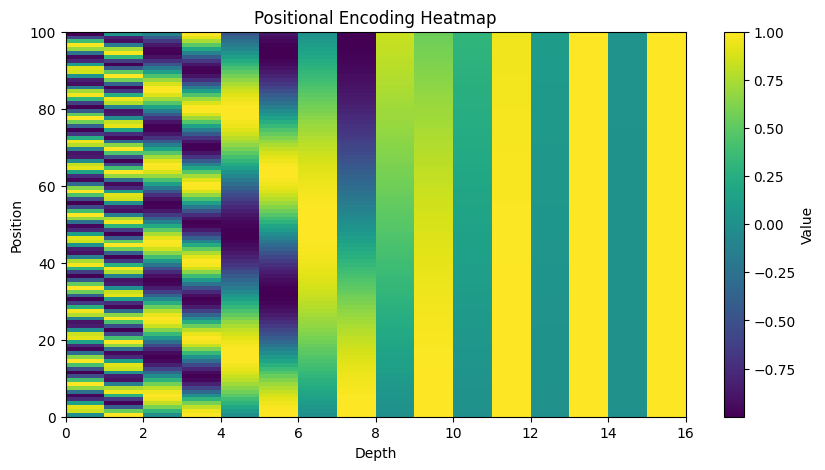

In [ ]:
# Generate encodings
length = 100
depth = 16
pe = positional_encoding(length, depth).numpy()

# Plot heatmap
plt.figure(figsize=(10, 5))
plt.pcolormesh(pe, cmap='viridis')
plt.xlabel("Depth")
plt.ylabel("Position")
plt.title("Positional Encoding Heatmap")
plt.colorbar(label="Value")
plt.show()

# LSTM baseline model

In [ ]:
from keras import Model, Input

def build_lstm(
    input_length,
    output_length,
    num_encoder_features,
    num_decoder_features,
    lstm_units=128,
    dense_units=64
):
    total_length = input_length + output_length

    # Inputs - combine them into the one sequence
    encoder_inputs = Input(shape=(input_length, num_encoder_features), name="encoder_inputs")
    decoder_inputs = Input(shape=(output_length, num_decoder_features), name="decoder_inputs")
    proj_enc = layers.TimeDistributed(layers.Dense(dense_units), name="proj_enc")(encoder_inputs)
    proj_dec = layers.TimeDistributed(layers.Dense(dense_units), name="proj_dec")(decoder_inputs)
    # encoder (history) first, decoder (forecast) data second
    combined = layers.Concatenate(axis=1, name="combined_sequence")([proj_enc, proj_dec])
    combined = layers.LayerNormalization()(combined)

    x = layers.LSTM(lstm_units, return_sequences=True, name="lstm")(combined)
    x = layers.LSTM(lstm_units, return_sequences=True, name="lstm2")(x)
    rrp_hidden = layers.TimeDistributed(layers.Dense(dense_units, activation=tf.keras.activations.gelu))(x)
    spike_hidden = layers.TimeDistributed(layers.Dense(dense_units, activation=tf.keras.activations.gelu))(x)
    demand_hidden = layers.TimeDistributed(layers.Dense(dense_units, activation=tf.keras.activations.gelu))(x)

    rrp_out = layers.TimeDistributed(layers.Dense(1))(rrp_hidden)
    spike_out = layers.TimeDistributed(layers.Dense(1, activation="sigmoid"))(spike_hidden)
    demand_out = layers.TimeDistributed(layers.Dense(1))(demand_hidden)

    rrp_output = layers.Lambda(lambda x: x[:, -output_length:, :], name="rrp_output")(rrp_out)
    spike_output = layers.Lambda(lambda x: x[:, -output_length:, :], name="spike_output")(spike_out)
    demand_output = layers.Lambda(lambda x: x[:, -output_length:, :], name="demand_output")(demand_out)

    return Model(inputs=[encoder_inputs, decoder_inputs], outputs=[rrp_output, demand_output, spike_output])

# Experiments

### functions

In [ ]:
class SeqPowerTransformer:
    """
    Yeo–Johnson transformer that preserves the original shape.
    Works with y shaped (N,), (N,F), (N,T,1) or (N,T,F).
    """
    def __init__(self, standardize=True):
        self.pt = PowerTransformer(method="yeo-johnson", standardize=standardize)

    def _to_2d(self, x):
        x = np.asarray(x)
        self._shape = x.shape
        if x.ndim == 1:
            return x.reshape(-1, 1)
        elif x.ndim == 2:
            return x
        else:  # flatten all but last dim
            return x.reshape(-1, x.shape[-1])

    def _from_2d(self, x2):
        return x2.reshape(self._shape)

    def fit(self, x):
        x2 = self._to_2d(x)
        self.pt.fit(x2)
        return self

    def transform(self, x):
        x2 = self._to_2d(x)
        return self._from_2d(self.pt.transform(x2))

    def fit_transform(self, x):
        x2 = self._to_2d(x)
        return self._from_2d(self.pt.fit_transform(x2))

    def inverse_transform(self, x):
        x2 = self._to_2d(x)
        return self._from_2d(self.pt.inverse_transform(x2))

def oversample_spikes(X_enc, X_dec, y, y_dem, spike_threshold=1.0, multiplier=5, noise_std = 0.02):
    """
    Oversample spike-containing samples to balance rare events.

    Args:
        X_enc: list or np.array of encoder input sequences
        X_dec: list or np.array of decoder input sequences
        y: list or np.array of target sequences
        spike_threshold: float, RRP value to define a spike
        multiplier: int, number of times to replicate spike samples

    Returns:
        Balanced (X_enc, X_dec, y)
    """
    X_enc, X_dec, y, y_dem = np.array(X_enc), np.array(X_dec), np.array(y), np.array(y_dem)

    spike_mask = np.max(y, axis=(1, 2)) > spike_threshold
    non_spike_mask = ~spike_mask

    X_enc_spike = X_enc[spike_mask]
    X_dec_spike = X_dec[spike_mask]
    y_spike = y[spike_mask]
    y_dem_spike = y_dem[spike_mask]

    # Oversample spikes
    X_enc_oversampled = np.repeat(X_enc_spike, multiplier, axis=0)
    X_dec_oversampled = np.repeat(X_dec_spike, multiplier, axis=0)
    y_oversampled = np.repeat(y_spike, multiplier, axis=0)
    y_dem_oversampled = np.repeat(y_dem_spike, multiplier, axis=0)

    # Add Gaussian noise to oversampled copies (but not to original non-spike data)
    X_enc_oversampled = X_enc_oversampled + np.random.normal(0, noise_std, X_enc_oversampled.shape)
    X_dec_oversampled = X_dec_oversampled + np.random.normal(0, noise_std, X_dec_oversampled.shape)
    # y_oversampled = y_oversampled + np.random.normal(0, noise_std, y_oversampled.shape)

    # Combine non-spike originals with oversampled spike copies
    X_enc_bal = np.concatenate([X_enc[non_spike_mask], X_enc_oversampled], axis=0)
    X_dec_bal = np.concatenate([X_dec[non_spike_mask], X_dec_oversampled], axis=0)
    y_bal = np.concatenate([y[non_spike_mask], y_oversampled], axis=0)
    y_dem_bal = np.concatenate([y_dem[non_spike_mask], y_dem_oversampled], axis=0)

    return X_enc_bal, X_dec_bal, y_bal, y_dem_bal

def mask_decoder_rrp(X_decoder, decoder_feature_cols, mask_value=0.0):
    """
    Mask the RRP feature in X_decoder only for timesteps t=1 and beyond.
    """
    if f"F_RRP_{region}" not in decoder_feature_cols:
        raise ValueError("RRP not found in decoder_feature_cols")

    rrp_index = decoder_feature_cols.index(f"F_RRP_{region}")
    # Mask all
    X_decoder[:, :, rrp_index] = mask_value
    return X_decoder

def visualize_training_sequence(
    idx,
    X_encoder_s, X_decoder_s, y_rrp_s,
    encoder_feature_cols, decoder_feature_cols,
    enc_scaler, dec_scaler, rrp_scaler,
    rrp_enc_col=f"RRP_{region}", rrp_dec_col=f"F_RRP_{region}",
    spike_threshold_unscaled=SPIKE_THRESHOLD,
    y_pred_rrp_s=None,
    df_index=None,
    base_offset=None,
    title_prefix="Training sequence",
):
    """
    Shows: past encoder RRP, decoder RRP input, target RRP (and optional prediction)
    All curves are inverse-transformed to $/MWh.
    If df_index & base_offset are provided, x-axis uses real timestamps; otherwise step indices.
    """

    # ---- shapes & indices ----
    Tin  = X_encoder_s.shape[1]
    Tout = X_decoder_s.shape[1]
    n_enc_feats = X_encoder_s.shape[2]
    n_dec_feats = X_decoder_s.shape[2]

    try:
        enc_rrp_i = encoder_feature_cols.index(rrp_enc_col)
    except ValueError:
        raise ValueError(f"'{rrp_enc_col}' not in encoder_feature_cols")

    try:
        dec_rrp_i = decoder_feature_cols.index(rrp_dec_col)
    except ValueError:
        raise ValueError(f"'{rrp_dec_col}' not in decoder_feature_cols")

    # ---- extract this sample (scaled) ----
    enc_rrp_s = X_encoder_s[idx, :, enc_rrp_i]
    dec_rrp_s = X_decoder_s[idx, :, dec_rrp_i]
    y_s  = y_rrp_s[idx, :, 0]

    # ---- inverse-scale helpers ----
    def _inv_feat_col(col_scaled, scaler, feat_idx, n_feats):
        tmp = np.zeros((col_scaled.shape[0], n_feats), dtype=np.float32)
        tmp[:, feat_idx] = col_scaled
        return scaler.inverse_transform(tmp)[:, feat_idx]

    enc_rrp_u = _inv_feat_col(enc_rrp_s, enc_scaler, enc_rrp_i, n_enc_feats)
    dec_rrp_u = _inv_feat_col(dec_rrp_s, dec_scaler, dec_rrp_i, n_dec_feats)
    y_rrp_u   = rrp_scaler.inverse_transform(y_s.reshape(-1,1)).ravel()

    y_pred_u = None
    if y_pred_rrp_s is not None:
        yp = np.asarray(y_pred_rrp_s).reshape(-1)
        if yp.shape[0] != Tout:
            raise ValueError(f"y_pred length {yp.shape[0]} != output_length {Tout}")
        y_pred_u = rrp_scaler.inverse_transform(yp.reshape(-1,1)).ravel()

    # ---- x-axis: timestamps (preferred) or step indices ----
    use_time = (df_index is not None) and (base_offset is not None)
    if use_time:
        start = int(base_offset) + int(idx)
        enc_x = df_index[start - Tin : start]
        dec_x = df_index[start : start + Tout]
    else:
        enc_x = np.arange(-Tin, 0)
        dec_x = np.arange(Tout)

    # ---- spikes on targets ----
    thr_u = float(spike_threshold_unscaled)
    spike_mask = y_rrp_u >= thr_u

    # ---- plot ----
    plt.figure(figsize=(12, 5))
    plt.plot(enc_x, enc_rrp_u, label="Encoder RRP (past)")
    plt.plot(dec_x, dec_rrp_u, label="Decoder F_RRP input")
    plt.plot(dec_x, y_rrp_u,   label="Target RRP")

    if y_pred_u is not None:
        plt.plot(dec_x, y_pred_u, linestyle="--", label="Predicted RRP")

    # plt.axhline(thr_u, linestyle=":", label=f"Spike threshold (${thr_u:,.0f}/MWh)")
    if spike_mask.any():
        plt.scatter(np.array(dec_x)[spike_mask], y_rrp_u[spike_mask], marker="x", label="Spike target")

    plt.title(f"{title_prefix} #{idx}  (Tin={Tin}, Tout={Tout})")
    plt.xlabel("Time" if use_time else "Steps (0 = first forecast horizon)")
    plt.ylabel("RRP ($/MWh)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

## data load

In [ ]:
# Load data
spike_resample_threshold = 91000  # In $, was $900
resample_multiplier = 10

seed = 111
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

X_encoder, X_decoder, y, y_dem, df_actual, df_nem_f = load_and_prepare_data(
    input_length=input_length,
    output_length=output_length,
    encoder_feature_cols=encoder_feature_cols,
    decoder_feature_cols=decoder_feature_cols,
    region=region,
    # force_refresh=True,
)

print("=== Data Debug ===")
print("X_encoder[0][0]:", X_encoder[0][0])
print("X_decoder[0][0]:", X_decoder[0][0])
print("y[0]:", y[0].flatten())

# Check ranges and NaNs
X_enc = np.array(X_encoder)
X_dec = np.array(X_decoder)
y_arr = np.array(y)
y_dem_arr = np.array(y_dem)

print("X_encoder shape:", X_enc.shape)
print("X_decoder shape:", X_dec.shape)
print("y shape:", y_arr.shape)

print("X_encoder max:", np.max(X_enc), "min:", np.min(X_enc))
print("X_decoder max:", np.max(X_dec), "min:", np.min(X_dec))
print("y max:", np.max(y_arr), "min:", np.min(y_arr))

print("Any NaNs in X_encoder?", np.isnan(X_enc).any())
print("Any NaNs in X_decoder?", np.isnan(X_dec).any())
print("Any NaNs in y?", np.isnan(y_arr).any())

📦 Loading data from cache: /content/drive/MyDrive/rrp_forecasting/cached_data_bare_i48_NSW1.npz
=== Data Debug ===
X_encoder[0][0]: [1.25916664e+02 8.50000009e-02 1.26904999e+02 1.09999999e-01
 8.50000009e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.94488019e-02 2.23791885e-05 2.27610040e-02 1.25916664e+02
 3.04666662e+00 1.26904999e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
X_decoder[0][0]: [ 1.25000000e+02  7.24523020e+00  1.34671341e+02  6.99388981e+00
  1.67339996e+02  6.42752002e+03  4.20202002e+03  5.27822021e+03
  1.31053003e+03  1.08000000e+03  1.25000000e+02  7.24523020e+00
  1.34671341e+02  1.15076685e+01  1.09024591e+01  3.01808310e+00
  8.16748428e+00  2.53573775e+00 -7.07106769e-01 -7.07106769e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.90000010e+00
  1.94476247e-02  2.55145375e-02  1.72422547e-03]
y[0]: [ 126.99167   128.41333   133.62833   103.24       72.665      62.336666
   22.888334    4.826667  

## Splitting and scaling

Training set size: (39596, 48, 20), (39596, 32, 1)
Test set size: (9867, 48, 20), (9867, 32, 1)
spike threshold scaled 3.0


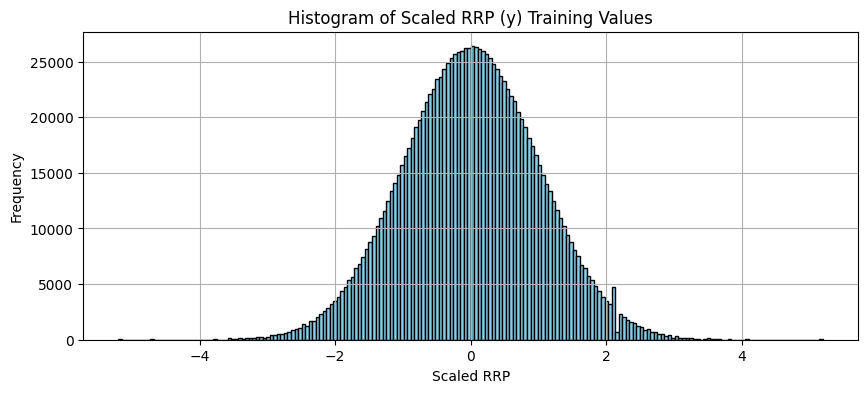

Number of training sequences: 39596
Encoder input shape: (39596, 48, 20)
Decoder input shape: (39596, 32, 27)
Target shape: (39596, 32, 1)


In [ ]:
n_samples = X_encoder.shape[0]
start = input_length
end = len(df_actual) - output_length
assert len(df_nem_f.index.get_level_values(0)) == len(df_actual) * output_length

# Split proportions. Add output_length to force gap between to stop any overlap leakage
n = len(X_encoder)
train_start = int(0 * n)
train_end = int(0.80 * n)
# val_start = train_end + output_length
# val_start = int(0.70 * n)
# val_end = int(0.80 * n)
test_start = train_end + output_length
test_end = int(1.0 * n)

# Truncate nem forecasts
run_times = df_nem_f.index.get_level_values("RUN_DATETIME").unique()
run_times_test = run_times[test_start:]
df_nem_f = df_nem_f[df_nem_f.index.get_level_values("RUN_DATETIME").isin(run_times_test)]

# Split encoder inputs
X_encoder_train = X_encoder[train_start:train_end]
# X_encoder_val = X_encoder[val_start:val_end]
X_encoder_test = X_encoder[test_start:test_end]

# Split decoder inputs
X_decoder_train = X_decoder[train_start:train_end]
# X_decoder_val = X_decoder[val_start:val_end]
X_decoder_test = X_decoder[test_start:test_end]

# Split targets
y_train = y[train_start:train_end]
# y_val = y[val_start:val_end]
y_test = y[test_start:test_end]

# Split targets
y_dem_train = y_dem[train_start:train_end]
# y_dem_val = y_dem[val_start:val_end]
y_dem_test = y_dem[test_start:test_end]

train_on_spikes_only = False
if train_on_spikes_only:
  spike_mask = np.max(y_train, axis=(1, 2)) > 900
  X_encoder_train = X_encoder_train[spike_mask]
  X_decoder_train = X_decoder_train[spike_mask]
  y_train = y_train[spike_mask]
  y_dem_train = y_dem_train[spike_mask]


print(f"Training set size: {X_encoder_train.shape}, {y_train.shape}")
# print(f"Validation set size: {X_encoder_val.shape}, {y_val.shape}")
print(f"Test set size: {X_encoder_test.shape}, {y_test.shape}")

# --- Fit scalers on TRAIN ONLY ---
# main_scaler = SeqPowerTransformer(standardize=True)
# main_scaler = QuantileTransformer(output_distribution="normal",
#                                  n_quantiles=min(5000, len(y_train)),
#                                  subsample=int(1e6), random_state=111)
main_scaler = RobustScaler()
# main_scaler = StandardScaler()

enc_scaler = clone(main_scaler).fit(
    X_encoder_train.reshape(-1, X_encoder_train.shape[-1])
)

dec_scaler = clone(main_scaler).fit(
    X_decoder_train.reshape(-1, X_decoder_train.shape[-1])
)

# rrp_scaler = SeqPowerTransformer(standardize=True).fit(
#     y_train.reshape(-1, y_train.shape[-1])
# )
rrp_scaler = clone(main_scaler).fit(
    y_train.reshape(-1, y_train.shape[-1])
)

dem_scaler = StandardScaler()
dem_scaler = dem_scaler.fit(
    y_dem_train.reshape(-1, y_dem_train.shape[-1])
)

# --- Save scalers ---
joblib.dump(enc_scaler, f"/content/drive/MyDrive/NEM/enc_scaler_i{input_length}_{region}.joblib")
joblib.dump(dec_scaler, f"/content/drive/MyDrive/NEM/dec_scaler_i{input_length}_{region}.joblib")
joblib.dump(rrp_scaler, f"/content/drive/MyDrive/NEM/rrp_scaler_i{input_length}_{region}.joblib")
joblib.dump(dem_scaler, f"/content/drive/MyDrive/NEM/dem_scaler_i{input_length}_{region}.joblib")

# --- Transform encoder inputs ---
X_encoder_train_s = enc_scaler.transform(X_encoder_train.reshape(-1, X_encoder_train.shape[-1])) \
                                .reshape(X_encoder_train.shape)
# X_encoder_val_s = enc_scaler.transform(X_encoder_val.reshape(-1, X_encoder_val.shape[-1])) \
#                                 .reshape(X_encoder_val.shape)
X_encoder_test_s = enc_scaler.transform(X_encoder_test.reshape(-1, X_encoder_test.shape[-1])) \
                                .reshape(X_encoder_test.shape)

# --- Transform decoder inputs ---
X_decoder_train_s = dec_scaler.transform(X_decoder_train.reshape(-1, X_decoder_train.shape[-1])) \
                                .reshape(X_decoder_train.shape)
# X_decoder_val_s = dec_scaler.transform(X_decoder_val.reshape(-1, X_decoder_val.shape[-1])) \
#                                 .reshape(X_decoder_val.shape)
X_decoder_test_s = dec_scaler.transform(X_decoder_test.reshape(-1, X_decoder_test.shape[-1])) \
                                .reshape(X_decoder_test.shape)

# --- Transform targets (RRP) ---
y_train_s = rrp_scaler.transform(y_train.reshape(-1, y_train.shape[-1])) \
                       .reshape(y_train.shape)
# y_val_s = rrp_scaler.transform(y_val.reshape(-1, y_val.shape[-1])) \
#                        .reshape(y_val.shape)
y_test_s = rrp_scaler.transform(y_test.reshape(-1, y_test.shape[-1])) \
                       .reshape(y_test.shape)

# --- Transform targets (Demand) ---
y_dem_train_s = dem_scaler.transform(y_dem_train.reshape(-1, y_dem_train.shape[-1])) \
                           .reshape(y_dem_train.shape)
# y_dem_val_s = dem_scaler.transform(y_dem_val.reshape(-1, y_dem_val.shape[-1])) \
#                            .reshape(y_dem_val.shape)
y_dem_test_s = dem_scaler.transform(y_dem_test.reshape(-1, y_dem_test.shape[-1])) \
                           .reshape(y_dem_test.shape)

# --- Spike threshold in TRAIN-SCALED space (for losses/metrics) ---
spike_thr_scaled = round(rrp_scaler.transform(np.array([[SPIKE_THRESHOLD]])).item(),1)
print("spike threshold scaled", spike_thr_scaled)

# Plot hist of y
rrp_scaled_flat = y_train_s.flatten()
plt.figure(figsize=(10, 4))
plt.hist(rrp_scaled_flat, bins=200, color='skyblue', edgecolor='black')
plt.title("Histogram of Scaled RRP (y) Training Values")
plt.xlabel("Scaled RRP")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# mask_rrp = False
# if mask_rrp:
#     # Masks predicted RRP in training set
#     X_decoder_train_s = mask_decoder_rrp(X_decoder_train_s, decoder_feature_cols, mask_value=0.0)

# Resample spikes in training set
X_encoder_train_s, X_decoder_train_s, y_train_s, y_dem_train_s = \
  oversample_spikes(X_encoder_train_s, X_decoder_train_s, y_train_s, y_dem_train_s, \
  spike_threshold=rrp_scaler.transform(np.array([[spike_resample_threshold]])).item(), multiplier=resample_multiplier)

# Create datasets
train_ds = create_seq2seq_dataset(X_encoder_train_s, X_decoder_train_s, y_train_s,
                                  y_dem_train_s, batch_size=batch_size,
                                  spike_threshold_scaled=spike_thr_scaled, shuffle=True)
# val_ds = create_seq2seq_dataset(X_encoder_val_s, X_decoder_val_s, y_val_s,
#                                 y_dem_val_s, batch_size=batch_size,
#                                 spike_threshold_scaled=spike_thr_scaled, shuffle=False)
test_ds = create_seq2seq_dataset(X_encoder_test_s, X_decoder_test_s, y_test_s,
                                 y_dem_test_s, batch_size=batch_size,
                                 spike_threshold_scaled=spike_thr_scaled, shuffle=False)

print("Number of training sequences:", X_encoder_train_s.shape[0])
print("Encoder input shape:", X_encoder_train_s.shape)
print("Decoder input shape:", X_decoder_train_s.shape)
print("Target shape:", y_train_s.shape)

### scaling check

In [ ]:
import numpy as np
import pandas as pd

# Flatten to 2D for column-wise stats
X3 = X_decoder_train
N, T, F = X3.shape
X = X3.reshape(-1, F).astype(np.float64, copy=False)

try:
    names = list(decoder_feature_cols)
    assert len(names) == F
except Exception:
    names = [f"dec_f{j}" for j in range(F)]

# Choose an "extreme" threshold
THRESH = 3e5

stats = []
for j in range(F):
    col = X[:, j]
    finite = np.isfinite(col)
    n = len(col)
    n_finite = finite.sum()
    n_nan = np.isnan(col).sum()
    n_posinf = np.isposinf(col).sum()
    n_neginf = np.isneginf(col).sum()
    n_extreme = np.sum(np.abs(col[finite]) > THRESH) if n_finite else 0

    max_abs = np.nanmax(np.abs(col[finite])) if n_finite else np.nan
    p999 = np.nanpercentile(np.abs(col[finite]), 99.9) if n_finite else np.nan
    p99  = np.nanpercentile(np.abs(col[finite]), 99.0) if n_finite else np.nan

    stats.append({
        "col_idx": j,
        "name": names[j],
        "n": n,
        "finite": int(n_finite),
        "nan": int(n_nan),
        "+inf": int(n_posinf),
        "-inf": int(n_neginf),
        f"|x|>{THRESH}": int(n_extreme),
        "max_abs": float(max_abs),
        "p99_abs": float(p99),
        "p999_abs": float(p999),
    })

df_report = pd.DataFrame(stats).sort_values(
    ["+inf", "-inf", f"|x|>{THRESH}", "max_abs"], ascending=[False, False, False, False]
).reset_index(drop=True)

print("=== Decoder column health report (sorted by most problematic) ===")
print(df_report.to_string(index=False))

# ---- Locate offending samples for the worst columns ----
# Show where NaN/Inf/Extreme values occur
TOP_K = 3  # how many columns to drill into
worst_cols = df_report["col_idx"].head(TOP_K).tolist()

for j in worst_cols:
    col3 = X3[:, :, j]  # back to (N, T) so we can find sample/time exactly
    bad_mask = ~np.isfinite(col3) | (np.abs(col3) > THRESH)
    idx = np.argwhere(bad_mask)
    if idx.size == 0:
        continue
    print(f"\n--- Offending entries for '{names[j]}' (col {j}) ---")
    # Show up to first 10 offending coordinates with values
    for (i, t) in idx[:10]:
        val = col3[i, t]
        print(f"sample={i}, time={t}, value={val!r}")


=== Decoder column health report (sorted by most problematic) ===
 col_idx                 name       n  finite  nan  +inf  -inf  |x|>300000.0      max_abs      p99_abs     p999_abs
       0           F_RRP_NSW1 1267072 1267072    0     0     0             0 17500.000000   661.020020 17499.960938
       1           F_RRP_VIC1 1267072 1267072    0     0     0             0 17500.000000   496.850471 15499.950195
       2           F_RRP_QLD1 1267072 1267072    0     0     0             0 17500.000000   737.858156 17490.000000
       3            F_RRP_SA1 1267072 1267072    0     0     0             0 17500.000000  1500.939941 16600.000000
       4           F_RRP_TAS1 1267072 1267072    0     0     0             0 17500.000000   450.140015 12466.355245
      10  F_rrp_min_past_NSW1 1267072 1267072    0     0     0             0 17500.000000   307.513179 17480.000000
      11  F_rrp_min_past_VIC1 1267072 1267072    0     0     0             0 17500.000000   356.292877  1000.000000
      

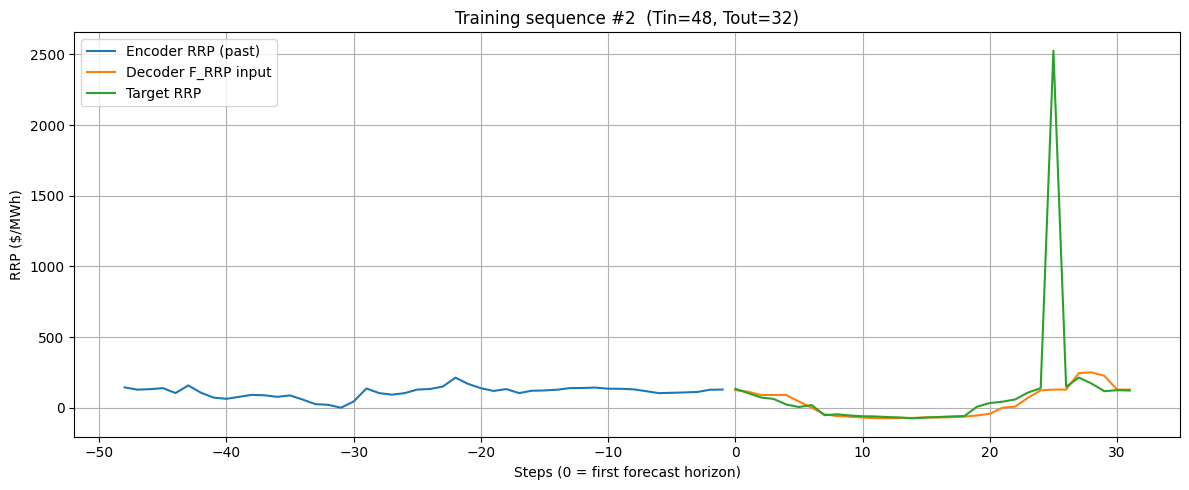

In [ ]:
visualize_training_sequence(
    idx=2,
    X_encoder_s=X_encoder_train_s,
    X_decoder_s=X_decoder_train_s,
    y_rrp_s=y_train_s,
    encoder_feature_cols=encoder_feature_cols,
    decoder_feature_cols=decoder_feature_cols,
    enc_scaler=enc_scaler,
    dec_scaler=dec_scaler,
    rrp_scaler=rrp_scaler,
    rrp_enc_col=f"RRP_{region}",
    rrp_dec_col=f"F_RRP_{region}",
    spike_threshold_unscaled=SPIKE_THRESHOLD,
)

## training

In [ ]:
epochs=20
# LR 5e-5, WD 1e-5 best for baseline
# LR 3e-4, WD 1e-6 best for spikes
learning_rate=2e-4  # was 2e-4
weight_decay=1e-4   # was 1e-4
global_clipnorm=1.0 # was 1.0

# # V Large model
# size="vlarge"
# d_model=1024
# num_heads=8
# ff_dim=2048
# num_layers=5
# dropout=0.10

# # Large model
# size="large"
# d_model=512
# num_heads=8
# ff_dim=2048
# num_layers=4
# dropout=0.10

# # Med
# size="med"
# d_model=256
# num_heads=4
# ff_dim=1024
# num_layers=3
# dropout=0.05

# Small
size="small"
d_model=128
num_heads=4
ff_dim=512
num_layers=3
dropout=0.05 # 0-0.05 for spikes, up to 0.30 for smoother baseline, was 0.10

# # Tiny
# size="tiny"
# d_model=64
# num_heads=2
# ff_dim=256
# num_layers=2
# dropout=0.05

def spike_weighted_mae(y_true, y_pred):
    spike_weight = tf.where(y_true > rrp_scaler.transform(np.array([[1000]])).item(), 10.0, 1.0)
    return tf.reduce_mean(spike_weight * tf.abs(y_true - y_pred))

# loss=spike_weighted_mae
# loss=tf.keras.losses.Huber(delta=0.5) # 0.5 closer to MAE, 1.0 balanced, 2.0 more MSE (higher spike penalty)
# loss=keras.losses.mean_squared_error
# loss=keras.losses.mean_absolute_error
# focal_loss(gamma=2.0, alpha=0.25), #"binary_crossentropy",
# delta = round(rrp_scaler.transform(np.array([[100]])).item(),1)
loss={
    "rrp_output": tf.keras.losses.Huber(delta=5.0), # delta=0.5 best for spikes, 10 best for baseline
    "demand_output": "mse",
    "spike_output": keras.losses.BinaryFocalCrossentropy(gamma=2.0, alpha=0.25, from_logits=False),
}
loss_weights={
    "rrp_output": 3.0,
    "demand_output": 0.1,
    "spike_output": 0.5,
}

ths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

spike_metrics = [
    tf.keras.metrics.AUC(name="spike_auc_pr", curve="PR", num_thresholds=200),
    tf.keras.metrics.AUC(name="spike_auc_roc", curve="ROC", num_thresholds=200),
    # *[tf.keras.metrics.Precision(thresholds=t, name=f"P@{t}") for t in ths],
    # *[tf.keras.metrics.Recall(thresholds=t, name=f"R@{t}") for t in ths],
    # tf.keras.metrics.PrecisionAtRecall(0.80, name="P@R>=0.80"),
    # tf.keras.metrics.RecallAtPrecision(0.50, name="R@P>=0.50"),
]

metrics = {
    "rrp_output": ["mae"],
    "demand_output": ["mae"],
    "spike_output": spike_metrics,
    }

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=1e-5,
#     beta_1=0.9,
#     beta_2=0.98,
#     epsilon=1e-7,
#     global_clipnorm=1.0,
# )

# Train model
early_stop = keras.callbacks.EarlyStopping(
    monitor='rrp_output_loss',
    patience=9,
    restore_best_weights=True,
    mode='min',
    min_delta=1e-3,
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="rrp_output_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

print("Number of training sequences:", X_encoder_train_s.shape[0])
print("Encoder input shape:", X_encoder.shape)
print("Decoder input shape:", X_decoder.shape)
print("Target shape:", y.shape)


for (enc_batch, dec_batch), targets in train_ds.take(1):
    print("Encoder batch shape:", enc_batch.shape)
    print("Decoder batch shape:", dec_batch.shape)

    print("RRP target shape    :", targets["rrp_output"].shape)
    print("Spike target shape  :", targets["spike_output"].shape)
    print("Demand target shape :", targets["demand_output"].shape)

def check_numerics(name, array):
    assert not np.isnan(array).any(), f"NaNs in {name}"
    assert np.isfinite(array).all(), f"Infs in {name}"

# check_numerics("X_encoder_val", X_encoder_val)
# check_numerics("X_decoder_val", X_decoder_val)
# check_numerics("y_val", y_val)

Number of training sequences: 39596
Encoder input shape: (49495, 48, 20)
Decoder input shape: (49495, 32, 27)
Target shape: (49495, 32, 1)
Encoder batch shape: (128, 48, 20)
Decoder batch shape: (128, 32, 27)
RRP target shape    : (128, 32, 1)
Spike target shape  : (128, 32, 1)
Demand target shape : (128, 32, 1)


## (Walk-forward) Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def walk_forward_valiation(splits=5):
    '''
    Loops through various splits, training on previous series only, and then aggregates the results.
    Chosen to get validation across a lot more data to better gauge performance.
    '''
    N = X_encoder_train.shape[0]
    tscv = TimeSeriesSplit(n_splits=splits, test_size=max(1, N // (splits+1)), gap=output_length)
    oof_pred = np.full_like(y_train, np.nan, dtype=float)
    fold_mae = []

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=9,
        restore_best_weights=True,
        mode='min',
        min_delta=1e-3,
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )

    for fold, (tr, te) in enumerate(tscv.split(np.arange(N)), 1):

          seed=111
          os.environ['PYTHONHASHSEED']=str(seed)
          random.seed(seed)
          np.random.seed(seed)
          tf.random.set_seed(seed)

          # --- Fit scalers on TRAIN ONLY ---

          enc_scaler = clone(main_scaler).fit(
              X_encoder_train[tr].reshape(-1, X_encoder_train.shape[-1])
          )
          dec_scaler = clone(main_scaler).fit(
              X_decoder_train[tr].reshape(-1, X_decoder_train.shape[-1])
          )
          rrp_scaler = clone(main_scaler).fit(
              y_train[tr].reshape(-1, y_train.shape[-1])
          )
          dem_scaler = StandardScaler()
          dem_scaler = dem_scaler.fit(
              y_dem_train[tr].reshape(-1, y_dem_train.shape[-1])
          )

          # for i, name in enumerate(encoder_feature_cols):
          #   tr_var = np.var(X_encoder_train[tr][:, i])
          #   te_var = np.var(X_encoder_train[te][:, i])
          #   if tr_var == 0 or te_var == 0:
          #       print(f"Feature {name} → train var={tr_var:.6f}, test var={te_var:.6f}")

          # Scale
          Xenc_tr = enc_scaler.transform(X_encoder_train[tr].reshape(-1, X_encoder_train.shape[-1])).reshape(X_encoder_train[tr].shape)
          Xdec_tr = dec_scaler.transform(X_decoder_train[tr].reshape(-1, X_decoder_train.shape[-1])).reshape(X_decoder_train[tr].shape)
          y_tr_s  = rrp_scaler.transform(y_train[tr].reshape(-1, 1)).reshape(y_train[tr].shape)
          y_dem_tr_s  = dem_scaler.transform(y_dem_train[tr].reshape(-1, 1)).reshape(y_dem_train[tr].shape)

          Xenc_te = enc_scaler.transform(X_encoder_train[te].reshape(-1, X_encoder_train.shape[-1])).reshape(X_encoder_train[te].shape)
          Xdec_te = dec_scaler.transform(X_decoder_train[te].reshape(-1, X_decoder_train.shape[-1])).reshape(X_decoder_train[te].shape)
          y_te_s  = rrp_scaler.transform(y_train[te].reshape(-1, 1)).reshape(y_train[te].shape)
          y_dem_te_s  = dem_scaler.transform(y_dem_train[te].reshape(-1, 1)).reshape(y_dem_train[te].shape)

          # Oversample spikes in training set
          Xenc_tr, Xdec_tr, y_tr_s, y_dem_tr_s = oversample_spikes(
              Xenc_tr, Xdec_tr, y_tr_s, y_dem_tr_s,
              spike_threshold=rrp_scaler.transform(np.array([[spike_resample_threshold]])).item(), multiplier=resample_multiplier)

          # create batches
          spike_thr_scaled = round(rrp_scaler.transform(np.array([[SPIKE_THRESHOLD]])).item(),1)
          cv_train_ds = create_seq2seq_dataset(Xenc_tr, Xdec_tr, y_tr_s, y_dem_tr_s,
                                              batch_size=batch_size,
                                              spike_threshold_scaled=spike_thr_scaled,
                                              shuffle=True)

          cv_val_ds = create_seq2seq_dataset(Xenc_te,
                                          Xdec_te, y_te_s, y_dem_te_s,
                                          batch_size=batch_size,
                                          spike_threshold_scaled=spike_thr_scaled,
                                          shuffle=False)

          # --- build & train fresh model ---
          model, attn_model = build_encoder_decoder_transformer_preLN2(
              input_length=input_length,
              output_length=output_length,
              num_features=Xenc_tr.shape[2],
              num_decoder_features=Xdec_tr.shape[2],
              d_model=d_model,
              num_heads=num_heads,
              ff_dim=ff_dim,
              num_layers=num_layers,
              dropout=dropout,
          )
          optimizer = tf.keras.optimizers.AdamW(
              learning_rate=learning_rate,
              weight_decay=weight_decay,
              beta_1=0.9, beta_2=0.98, epsilon=1e-7, global_clipnorm=global_clipnorm,
          )
          model.compile(optimizer=optimizer, loss=loss, loss_weights=loss_weights, metrics=metrics)
          model.fit(cv_train_ds, validation_data=cv_val_ds,
                    epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False,
                    callbacks=[reduce_lr,keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)])

          # --- predict, inverse-scale, score ---
          yhat_s = model.predict([Xenc_te, Xdec_te], verbose=0)[0]
          yhat = rrp_scaler.inverse_transform(yhat_s.reshape(-1, 1)).reshape(yhat_s.shape)
          oof_pred[te] = yhat
          # print("NaNs in raw model output:", np.isnan(yhat_s).any())
          # print("NaNs in after inverse:", np.isnan(yhat).any())

          fold_mae.append(mean_absolute_error(y_train[te].ravel(), yhat.ravel()))
          print(f"[Fold {fold}] MAE=${fold_mae[-1]:.2f} (n_train={Xenc_tr.shape[0]}, n_test={len(te)})")

    # ---- aggregate ----
    valid = ~np.isnan(oof_pred).any(axis=1)
    valid = np.asarray(valid).reshape(-1)
    oof_pred = np.asarray(oof_pred)
    if oof_pred.ndim == 3 and oof_pred.shape[-1] == 1:
        oof_pred = oof_pred[..., 0]
    y_full=y_train[..., 0] if (y_train.ndim == 3 and y_train.shape[-1] == 1) else y_train
    y_full = np.asarray(y_full)
    # print(oof_pred.shape, y_full.shape, valid.shape)
    print(f"OOF MAE: ${mean_absolute_error(y_full[valid].ravel(), oof_pred[valid].ravel()):.2f}")
    print(f"Per-fold MAE:{fold_mae}")
    for h in (4, 8, 16, 24, 32):
        if 1 <= h <= output_length:
            print(f"hr={h//2}: MAE=${mean_absolute_error(y_full[valid, h-1], oof_pred[valid, h-1]):.1f}")

#walk_forward_valiation()

## Build Final Model

In [ ]:
import time

seed=111
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# epochs = 20

# Transformer model
model, attn_model = build_encoder_decoder_transformer_preLN2(
    input_length=input_length,
    output_length=output_length,
    num_features=X_encoder_train_s.shape[2],
    num_decoder_features=X_decoder_train_s.shape[2],
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    dropout=dropout,
)

# With L2 regularisation added
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    beta_1=0.9, beta_2=0.98, epsilon=1e-7, global_clipnorm=global_clipnorm,
)

model.compile(optimizer=optimizer, loss=loss, loss_weights=loss_weights, metrics=metrics)
start = time.time()
history = model.fit(train_ds, epochs=epochs, callbacks=[reduce_lr,early_stop])
end = time.time()
print(f"Fit took {end - start:.2f} seconds")

# Evaluate model
results = model.evaluate(test_ds)
print(dict(zip(model.metrics_names, results)))

model.save(f'/content/drive/MyDrive/NEM/transformer_model_i{input_length}_{size}_{region}.keras', include_optimizer=False)

Epoch 1/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 54s 64ms/step - demand_output_loss: 0.2971 - demand_output_mae: 0.3840 - loss: 0.5826 - rrp_output_loss: 0.1835 - rrp_output_mae: 0.4388 - spike_output_loss: 0.0047 - spike_output_spike_auc_pr: 0.0226 - spike_output_spike_auc_roc: 0.8850 - learning_rate: 2.0000e-04
Epoch 2/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - demand_output_loss: 0.0647 - demand_output_mae: 0.1929 - loss: 0.3518 - rrp_output_loss: 0.1148 - rrp_output_mae: 0.3440 - spike_output_loss: 0.0017 - spike_output_spike_auc_pr: 0.1785 - spike_output_spike_auc_roc: 0.9838 - learning_rate: 2.0000e-04
Epoch 3/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - demand_output_loss: 0.0532 - demand_output_mae: 0.1737 - loss: 0.3288 - rrp_output_loss: 0.1076 - rrp_output_mae: 0.3322 - spike_output_loss: 0.0015 - spike_output_spike_auc_pr: 0.2522 - spike_output_spike_auc_roc: 0.9891 - learning_rate: 2.0000e-04
Epoch 4/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - demand_output_loss: 0.0478

## LSTM

In [ ]:
train_LSTM = True
if train_LSTM:
  seed=111
  os.environ['PYTHONHASHSEED']=str(seed)
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

  # epochs = 20

  LSTM_optimizer = tf.keras.optimizers.AdamW(
      learning_rate=learning_rate,
      weight_decay=weight_decay,
      beta_1=0.9, beta_2=0.98, epsilon=1e-7, global_clipnorm=global_clipnorm,
  )

  # LSTM
  LSTM_model = build_lstm(input_length=input_length, output_length=output_length, num_encoder_features=X_encoder_train_s.shape[2], num_decoder_features=X_decoder_train_s.shape[2])
  LSTM_model.compile(optimizer=LSTM_optimizer, loss=loss, loss_weights=loss_weights, metrics=metrics)
  start = time.time()
  LSTM_history = LSTM_model.fit(train_ds, epochs=epochs, callbacks=[reduce_lr])
  end = time.time()
  print(f"Fit took {end - start:.2f} seconds")

  # Evaluate model
  LSTM_results = LSTM_model.evaluate(test_ds)
  print(dict(zip(LSTM_model.metrics_names, LSTM_results)))

  LSTM_model.save(f'/content/drive/MyDrive/NEM/LSTM_model_i{input_length}_{region}.keras')
else:
  LSTM_model = keras.models.load_model(
      f'/content/drive/MyDrive/NEM/LSTM_model_i{input_length}_{region}.keras',
      # custom_objects={'spike_weighted_mae': spike_weighted_mae},
      compile=True,
      safe_mode=False
  )


Epoch 1/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 103ms/step - demand_output_loss: 0.5233 - demand_output_mae: 0.5320 - loss: 0.7111 - rrp_output_loss: 0.2146 - rrp_output_mae: 0.4839 - spike_output_loss: 0.0298 - spike_output_spike_auc_pr: 0.0044 - spike_output_spike_auc_roc: 0.7377 - learning_rate: 2.0000e-04
Epoch 2/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - demand_output_loss: 0.0978 - demand_output_mae: 0.2366 - loss: 0.3447 - rrp_output_loss: 0.1113 - rrp_output_mae: 0.3379 - spike_output_loss: 0.0021 - spike_output_spike_auc_pr: 0.0851 - spike_output_spike_auc_roc: 0.9651 - learning_rate: 2.0000e-04
Epoch 3/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - demand_output_loss: 0.0688 - demand_output_mae: 0.1961 - loss: 0.3220 - rrp_output_loss: 0.1047 - rrp_output_mae: 0.3274 - spike_output_loss: 0.0018 - spike_output_spike_auc_pr: 0.1784 - spike_output_spike_auc_roc: 0.9742 - learning_rate: 2.0000e-04
Epoch 4/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - demand_output_loss: 0.

In [ ]:
def compute_sma_forecast(prices, window):
    """Compute simple moving average of RRP for each 30-minute time-of-day slot over the past N days."""
    df = prices.copy().reset_index()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Extract date and 30m slot (0–47)
    df['date'] = df['timestamp'].dt.date
    df['slot'] = df['timestamp'].dt.hour * 2 + df['timestamp'].dt.minute // 30
    # Sort by slot and date
    df = df.sort_values(['slot', 'date'])
    # Compute rolling mean per slot, shifted forward to avoid leakage
    df['sma_forecast'] = (
        df.groupby('slot')[f"RRP"]
        .transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    )
    df = df.sort_values('timestamp').reset_index(drop=True)
    return df[['timestamp', 'sma_forecast']]

sma_df = compute_sma_forecast(df_actual, window=7)

test_start_ts = df_actual.index[test_start]
print(test_start_ts)
# Align SMA baseline to model's test window
sma_df = sma_df[sma_df["timestamp"] >= test_start_ts].reset_index(drop=True)
y_sma = sma_df["sma_forecast"].to_numpy()
# df_actual=df_actual.iloc[test_start:]
# print(sma_df.head())
# print(df_actual.head())

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# === Sample index ===
# i = 615 # 2718, 1338, 615 spikes

# rrp_index_enc = encoder_feature_cols.index(f"RRP_{region}")
# rrp_index_dec = decoder_feature_cols.index(f"F_RRP_{region}")
# dem_index_dec = decoder_feature_cols.index(f"F_TOTALDEMAND_{region}")

# print(rrp_index_dec)
if "LAST_RRP" in decoder_feature_cols:
  rrp_index_last = decoder_feature_cols.index("LAST_RRP")
# rrp_index_all = all_feature_cols.index("RRP")

X_enc_np = np.concatenate([x[0] for x, _ in test_ds], axis=0)
X_dec_np = np.concatenate([x[1] for x, _ in test_ds], axis=0)
y_test_np = np.concatenate([y["rrp_output"] for _, y in test_ds], axis=0)
y_spike_np = np.concatenate([y["spike_output"] for _, y in test_ds], axis=0)
y_demand_np = np.concatenate([y["demand_output"] for _, y in test_ds], axis=0)

n_samples, output_length, _ = X_dec_np.shape
# run_times = df_nem_f.index.get_level_values("RUN_DATETIME")
all_times=df_actual.index[test_start+input_length:]

# print(rrp_index_enc)
# print(rrp_index_dec)
# print(dem_index_dec)

## Inference Samples

In [ ]:
for i in (125,126):
    if i>n_samples:
      break
    X_enc_i = X_enc_np[i:i+1].copy()
    X_dec_i = X_dec_np[i:i+1].copy()
    # print(X_enc_i,X_dec_i)

    # if "LAST_RRP" in decoder_feature_cols and not mask_rrp:
    #   last_known_rrp = X_enc_np[i, -1, rrp_index_enc]
    #   X_dec_i[0, :, rrp_index_last] = last_known_rrp
    #   print("Last RRP:", last_known_rrp)

    y_pred_i = model.predict([X_enc_i, X_dec_i], verbose=0)
    y_pred_rrp_i = y_pred_i[0].reshape(-1)
    y_pred_dem_i = y_pred_i[1].reshape(-1)
    y_pred_spike_i = y_pred_i[2].reshape(-1)
    # print(y_pred_spike_i)

    y_pred_lstm_i = LSTM_model.predict([X_enc_i, X_dec_i], verbose=0)

    f_sma_i = y_sma[i:i+output_length]

    y_pred_i_unscaled = rrp_scaler.inverse_transform(y_pred_rrp_i.reshape(-1, 1))
    y_pred_lstm_i_unscaled = rrp_scaler.inverse_transform(y_pred_lstm_i[0].reshape(-1, 1))
    y_pred_dem_i_unscaled = dem_scaler.inverse_transform(y_pred_dem_i.reshape(-1, 1))
    # print("scaled pred:", y_pred_rrp_i)
    # print("unscaled pred:",y_pred_i_unscaled)
    y_true_i_unscaled = y_test[i]
    run_time_i = all_times[i]
    print("Run time:", run_time_i)
    # print("y_true[:5]:", y_true_i_unscaled, "y_pred[:5]:", y_pred_lstm_i_unscaled)
    f_rrp_unscaled_i = df_nem_f["F_RRP"].loc[run_time_i].values #X_decoder_test[i,:,rrp_index_dec]
    f_demand_i_unscaled = df_nem_f["F_TOTALDEMAND"].loc[run_time_i].values

    timestamps = all_times[i:i+output_length] - pd.Timedelta('30min')

    from sklearn.metrics import mean_absolute_error
    import matplotlib.dates as mdates

    mae_pred = mean_absolute_error(y_true_i_unscaled, y_pred_i_unscaled)
    mae_frrp = mean_absolute_error(y_true_i_unscaled, f_rrp_unscaled_i)
    mae_fsma = mean_absolute_error(y_true_i_unscaled, f_sma_i)
    mae_lstm = mean_absolute_error(y_true_i_unscaled, y_pred_lstm_i_unscaled)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 2]})

    # === Main RRP chart ===
    # ax1.plot(prev_timestamps, prev_rrp_unscaled, label="Previous RRP", linestyle="dotted", color="gray")
    ax1.plot(timestamps, y_true_i_unscaled, label="True RRP")
    ax1.plot(timestamps, y_pred_i_unscaled, label=f"Predicted RRP (MAE: {mae_pred:.1f})", linestyle="--")
    ax1.plot(timestamps, f_rrp_unscaled_i, label=f"NEM Forecast RRP (MAE: {mae_frrp:.1f})", linestyle=":")
    ax1.plot(timestamps,  y_pred_lstm_i_unscaled, label=f"LSTM Predicted RRP (MAE: {mae_lstm:.1f})", linestyle=":")
    ax1.plot(timestamps, f_sma_i, label=f"SMA Forecast RRP (MAE: {mae_fsma:.1f})", linestyle=":")
    ax1.set_ylabel("RRP ($/MWh)")
    ax1.set_title(f"Forecast vs Truth vs AEMO F_RRP vs LSTM (Sample {i})")
    ax1.legend()
    ax1.grid(True)

    # === Spike probability chart ===
    ax2.plot(timestamps, y_pred_spike_i, label="Spike Probability", linestyle="dashdot", alpha=0.7)
    ax2.set_ylabel("Spike Prob")
    # ax2.set_xlabel("Forecast Horizon")
    ax2.set_ylim(-0.1, 1.1)  # probability range
    ax2.grid(True)
    ax2.legend()

    # === Demand chart ===
    ax3.plot(timestamps, y_dem_test[i], label=f"True Demand")
    ax3.plot(timestamps, y_pred_dem_i_unscaled, label="Predicted Demand", linestyle="--")
    ax3.plot(timestamps, f_demand_i_unscaled, label="NEM Forecast Demand", linestyle=":")
    ax3.set_ylabel("Demand")
    ax3.set_xlabel("Forecast Horizon")
    ax3.grid(True)
    ax3.legend()

    # === Format x-axis (shared) ===
    plt.xticks(rotation=90)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))

    plt.tight_layout()
    plt.show()

In [ ]:
# Your decoder input array
dec_input = X_dec_i  # shape (1, 32, 19)

# Remove batch dimension: now (32, 19)
dec_seq = dec_input[0]

# Sanity check
assert dec_seq.shape[1] == len(decoder_feature_cols), \
    f"Feature count mismatch: {dec_seq.shape[1]} vs {len(decoder_feature_cols)}"

# Print values per feature
for i, feature in enumerate(decoder_feature_cols):
    values = dec_seq[:, i]
    print(f"{feature}: {values.tolist()}")

## Inference Evaluation

In [ ]:
# n_samples, output_length, _ = X_dec_np.shape
df_nem_f = df_nem_f.sort_index()
y_true_all = []
y_pred_all = []
y_pred_LSTM_all = []
f_rrp_all = []
f_sma_all = []

import time

print("Predicting with Transformer...")
start = time.time()
y_pred_all_scaled = model.predict([X_enc_np, X_dec_np], verbose=1)
end = time.time()
print(f"Transformer predict took {end - start:.2f} seconds")

y_pred_rrp_all_scaled = y_pred_all_scaled[0].reshape(n_samples, output_length)
y_pred_demand_all_scaled = y_pred_all_scaled[1].reshape(n_samples, output_length)
y_pred_spike_all_scaled = y_pred_all_scaled[2].reshape(n_samples, output_length)

print("Predicting with LSTM...")
start = time.time()
y_pred_LSTM_all_scaled = LSTM_model.predict([X_enc_np, X_dec_np], verbose=1)
end = time.time()
print(f"LSTM predict took {end - start:.2f} seconds")

y_pred_LSTM_rrp_all_scaled = y_pred_LSTM_all_scaled[0].reshape(n_samples, output_length)


for i in range(n_samples):
    if i % 300 == 0:
        print(f"Sample {i}/{n_samples}")

    # Get encoder + decoder input
    X_enc_i = X_enc_np[i:i+1]
    X_dec_i = X_dec_np[i:i+1].copy()

    # Just check that we aren't bleeding actuals into the inputs
    # if i == 0:
    #   assert X_enc_np[i, -1, rrp_index_enc] != y_pred_rrp_all_scaled[i, 0]
      # assert X_dec_np[i, -1, rrp_index_dec] != y_pred_rrp_all_scaled[i, 0]

    # if not mask_rrp and "LAST_RRP" in decoder_feature_cols:
    #   # Seed decoder RRP input at t=0
    #   last_known_rrp = X_enc_np[i, -1, rrp_index_enc]
    #   X_dec_i[0, :, rrp_index_last] = last_known_rrp

    # Predict
    y_pred_rrp_i = y_pred_rrp_all_scaled[i]
    y_pred_spike_i = y_pred_spike_all_scaled[i]
    y_pred_demand_i = y_pred_demand_all_scaled[i]
    y_pred_LSTM_rrp_i = y_pred_LSTM_rrp_all_scaled[i]

    y_pred_unscaled = rrp_scaler.inverse_transform(y_pred_rrp_i.reshape(-1,1))
    y_pred_LSTM_unscaled = rrp_scaler.inverse_transform(y_pred_LSTM_rrp_i.reshape(-1,1))
    y_true_unscaled = y_test[i].reshape(-1)
    np.isclose(y_true_unscaled[0], df_actual.iloc[i][f"RRP"], rtol=1e-5), f"Mismatch at sample {i}"
    run_time_i = all_times[i]
    y_rrp_unscaled = df_nem_f["F_RRP"].loc[run_time_i] # X_decoder_test[i,:,rrp_index_dec]


    y_sma_unscaled = y_sma[i:i+output_length]

    assert len(y_pred_unscaled) == output_length
    assert len(y_pred_LSTM_unscaled) == output_length
    assert len(y_true_unscaled) == output_length
    assert len(y_rrp_unscaled) == output_length
    assert len(y_sma_unscaled) == output_length

    y_pred_all.append(y_pred_unscaled)
    y_pred_LSTM_all.append(y_pred_LSTM_unscaled)
    y_true_all.append(y_true_unscaled)
    f_rrp_all.append(y_rrp_unscaled)
    f_sma_all.append(y_sma_unscaled)

print("Stacking...")
# Stack into arrays
y_pred_all = np.concatenate(y_pred_all)
y_pred_LSTM_all = np.concatenate(y_pred_LSTM_all)
y_true_all = np.concatenate(y_true_all)
f_rrp_all = np.concatenate(f_rrp_all)
f_sma_all =  np.concatenate(f_sma_all)

assert len(y_pred_all) == len(y_true_all) == len(f_rrp_all) == len(f_sma_all)

# Reshape to (n_samples, output_length)
y_true_all_2d = y_true_all.reshape(-1, output_length)
y_pred_all_2d = y_pred_all.reshape(-1, output_length)
y_pred_LSTM_all_2d = y_pred_LSTM_all.reshape(-1, output_length)
f_sma_all_2d = f_sma_all.reshape(-1, output_length)
f_rrp_all_2d = f_rrp_all.reshape(-1, output_length)



In [ ]:
def mae_at_fixed_horizons(y_true, y_pred, horizons=(2,4,8,12,16)):
    """
    y_true, y_pred: arrays of shape [N, H]
    horizons: iterable of horizons to score
    """
    H = y_true.shape[1]
    idxs = [h for h in horizons]
    # keep only horizons that exist
    valid = [(h, i*2-1) for h, i in zip(horizons, idxs) if 0 <= i*2 <= H]

    scores = {}
    for h, i in valid:
        scores[h] = round(mean_absolute_error(y_true[:, i], y_pred[:, i]),2)
    return scores

# Mask full sequences where any timestep >= 5000
# SPIKE_THRESHOLD = 500
spike_mask = (y_true_all_2d >= SPIKE_THRESHOLD).any(axis=1)
# assert len(y_true_all_2d[spike_mask].flatten()) > 0

model_mae = mae_at_fixed_horizons(y_true_all_2d, y_pred_all_2d)
LSTM_mae = mae_at_fixed_horizons(y_true_all_2d, y_pred_LSTM_all_2d)
aemo_mae = mae_at_fixed_horizons(y_true_all_2d, f_rrp_all_2d)
sma_mae = mae_at_fixed_horizons(y_true_all_2d, f_sma_all_2d)

try:
  spikes_model_mae = mae_at_fixed_horizons(y_true_all_2d[spike_mask], y_pred_all_2d[spike_mask])
  spikes_LSTM_mae = mae_at_fixed_horizons(y_true_all_2d[spike_mask], y_pred_LSTM_all_2d[spike_mask])
  spikes_aemo_mae = mae_at_fixed_horizons(y_true_all_2d[spike_mask], f_rrp_all_2d[spike_mask])
  spikes_sma_mae = mae_at_fixed_horizons(y_true_all_2d[spike_mask], f_sma_all_2d[spike_mask])
except ValueError:
  spikes_model_mae = {}
  spikes_LSTM_mae = {}
  spikes_aemo_mae = {}
  spikes_sma_mae = {}

nonspikes_model_mae = mae_at_fixed_horizons(y_true_all_2d[~spike_mask], y_pred_all_2d[~spike_mask])
nonspikes_LSTM_mae = mae_at_fixed_horizons(y_true_all_2d[~spike_mask], y_pred_LSTM_all_2d[~spike_mask])
nonspikes_aemo_mae = mae_at_fixed_horizons(y_true_all_2d[~spike_mask], f_rrp_all_2d[~spike_mask])
nonspikes_sma_mae = mae_at_fixed_horizons(y_true_all_2d[~spike_mask], f_sma_all_2d[~spike_mask])

records = {}
for horizon in [2, 4, 8, 12, 16]:
    for metric, m_mae, l_mae, a_mae, s_mae in [
        ("spike", spikes_model_mae, spikes_LSTM_mae, spikes_sma_mae, spikes_aemo_mae),
        ("non.", nonspikes_model_mae, nonspikes_LSTM_mae, nonspikes_sma_mae, nonspikes_aemo_mae),
        ("all", model_mae, LSTM_mae, sma_mae, aemo_mae),
    ]:
        records[(horizon, metric)] = [
            m_mae[horizon],
            l_mae[horizon],
            a_mae[horizon],
            s_mae[horizon],
        ]

columns = pd.MultiIndex.from_tuples(records.keys(), names=["Horizon", "Metric"])
mae_df = pd.DataFrame(records, index=["Transformer", "LSTM", "SMA-7d", "NEM"])
mae_df = mae_df[columns]

styled = (
    mae_df.style
    .format("${:.2f}", na_rep="—")
    .set_table_styles(
        [ {"selector": "th.col0_level0", "props": [("font-weight", "bold"), ("text-align", "center")]} ],
        overwrite=False
    )
)

display(styled)

In [ ]:
records = {}
for horizon in [2, 4, 8, 12, 16]:
    for metric, m_mae, l_mae, a_mae, s_mae in [
        ("all", model_mae, LSTM_mae, sma_mae, aemo_mae),
    ]:
        records[(horizon, metric)] = [
            m_mae[horizon],
            l_mae[horizon],
            a_mae[horizon],
            s_mae[horizon],
        ]

columns = pd.MultiIndex.from_tuples(records.keys(), names=["Horizon", "Metric"])
mae_df = pd.DataFrame(records, index=["Transformer", "LSTM", "SMA-7d", "NEM"])
mae_df = mae_df[columns]

styled = (
    mae_df.style
    .format("${:.2f}", na_rep="—")
    .set_table_styles(
        [ {"selector": "th.col0_level0", "props": [("font-weight", "bold"), ("text-align", "center")]} ],
        overwrite=False
    )
)

display(styled)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

def rms_at_fixed_horizons(y_true, y_pred, horizons=(2,4,8,12,16)):
    """
    y_true, y_pred: arrays of shape [N, H]
    horizons: iterable of horizons to score
    """
    H = y_true.shape[1]
    idxs = [h for h in horizons]
    # keep only horizons that exist
    valid = [(h, i*2-1) for h, i in zip(horizons, idxs) if 0 <= i*2 <= H]

    scores = {}
    for h, i in valid:
        scores[h] = round(root_mean_squared_error(y_true[:, i], y_pred[:, i]),2)
    return scores


model_rms = rms_at_fixed_horizons(y_true_all_2d, y_pred_all_2d)
LSTM_rms = rms_at_fixed_horizons(y_true_all_2d, y_pred_LSTM_all_2d)
aemo_rms = rms_at_fixed_horizons(y_true_all_2d, f_rrp_all_2d)
sma_rms = rms_at_fixed_horizons(y_true_all_2d, f_sma_all_2d)

try:
  spikes_model_rms = rms_at_fixed_horizons(y_true_all_2d[spike_mask], y_pred_all_2d[spike_mask])
  spikes_LSTM_rms = rms_at_fixed_horizons(y_true_all_2d[spike_mask], y_pred_LSTM_all_2d[spike_mask])
  spikes_aemo_rms = rms_at_fixed_horizons(y_true_all_2d[spike_mask], f_rrp_all_2d[spike_mask])
  spikes_sma_rms = rms_at_fixed_horizons(y_true_all_2d[spike_mask], f_sma_all_2d[spike_mask])
except ValueError:
  spikes_model_rms = {}
  spikes_LSTM_rms = {}
  spikes_aemo_rms = {}
  spikes_sma_rms = {}

nonspikes_model_rms = rms_at_fixed_horizons(y_true_all_2d[~spike_mask], y_pred_all_2d[~spike_mask])
nonspikes_LSTM_rms = rms_at_fixed_horizons(y_true_all_2d[~spike_mask], y_pred_LSTM_all_2d[~spike_mask])
nonspikes_aemo_rms = rms_at_fixed_horizons(y_true_all_2d[~spike_mask], f_rrp_all_2d[~spike_mask])
nonspikes_sma_rms = rms_at_fixed_horizons(y_true_all_2d[~spike_mask], f_sma_all_2d[~spike_mask])

records = {}
for horizon in [2, 4, 8, 12, 16]:
    for metric, m_rms, l_rms, a_rms, s_rms in [
        # ("spike", spikes_model_rms, spikes_LSTM_rms, spikes_sma_rms, spikes_aemo_rms),
        # ("non.", nonspikes_model_rms, nonspikes_LSTM_rms, nonspikes_sma_rms, nonspikes_aemo_rms),
        ("all", model_rms, LSTM_rms, sma_rms, aemo_rms),
    ]:
        records[(horizon, metric)] = [
            m_rms[horizon],
            l_rms[horizon],
            a_rms[horizon],
            s_rms[horizon],
        ]

columns = pd.MultiIndex.from_tuples(records.keys(), names=["Horizon", "Metric"])
mae_df = pd.DataFrame(records, index=["Transformer", "LSTM", "SMA-7d", "NEM"])
mae_df = mae_df[columns]

styled = (
    mae_df.style
    .format("${:.2f}", na_rep="—")
    .set_table_styles(
        [ {"selector": "th.col0_level0", "props": [("font-weight", "bold"), ("text-align", "center")]} ],
        overwrite=False
    )
)

display(styled)

In [ ]:
def mape_at_fixed_horizons(y_true, y_pred, horizons=(2,4,8,12,16)):
    """
    symmetric MAPE calculations
    y_true, y_pred: arrays of shape [N, H]
    horizons: iterable of horizons to score
    """
    H = y_true.shape[1]
    idxs = [h for h in horizons]
    # keep only horizons that exist
    valid = [(h, i*2-1) for h, i in zip(horizons, idxs) if 0 <= i*2 <= H]

    scores = {}
    for h, i in valid:
        yt=y_true[:, i]
        yp=y_pred[:, i]
        denom = np.abs(yt) + np.abs(yp)
        smape = 200.0 * np.mean(np.abs(yt - yp) / np.maximum(denom, 1e-9))
        scores[h] = round(smape, 2)
    return scores


model_mape = mape_at_fixed_horizons(y_true_all_2d, y_pred_all_2d)
LSTM_mape = mape_at_fixed_horizons(y_true_all_2d, y_pred_LSTM_all_2d)
aemo_mape = mape_at_fixed_horizons(y_true_all_2d, f_rrp_all_2d)
sma_mape = mape_at_fixed_horizons(y_true_all_2d, f_sma_all_2d)

try:
  spikes_model_mape = mape_at_fixed_horizons(y_true_all_2d[spike_mask], y_pred_all_2d[spike_mask])
  spikes_LSTM_mape = mape_at_fixed_horizons(y_true_all_2d[spike_mask], y_pred_LSTM_all_2d[spike_mask])
  spikes_aemo_mape = mape_at_fixed_horizons(y_true_all_2d[spike_mask], f_rrp_all_2d[spike_mask])
  spikes_sma_mape = mape_at_fixed_horizons(y_true_all_2d[spike_mask], f_sma_all_2d[spike_mask])
except ValueError:
  spikes_model_mape = {}
  spikes_LSTM_mape = {}
  spikes_aemo_mape = {}
  spikes_sma_mape = {}

nonspikes_model_mape = mape_at_fixed_horizons(y_true_all_2d[~spike_mask], y_pred_all_2d[~spike_mask])
nonspikes_LSTM_mape = mape_at_fixed_horizons(y_true_all_2d[~spike_mask], y_pred_LSTM_all_2d[~spike_mask])
nonspikes_aemo_mape = mape_at_fixed_horizons(y_true_all_2d[~spike_mask], f_rrp_all_2d[~spike_mask])
nonspikes_sma_mape = mape_at_fixed_horizons(y_true_all_2d[~spike_mask], f_sma_all_2d[~spike_mask])

records = {}
for horizon in [2, 4, 8, 12, 16]:
    for metric, m_mape, l_mape, a_mape, s_mape in [
        # ("spike", spikes_model_mape, spikes_LSTM_mape, spikes_sma_mape, spikes_aemo_mape),
        # ("non.", nonspikes_model_mape, nonspikes_LSTM_mape, nonspikes_sma_mape, nonspikes_aemo_mape),
        ("all", model_mape, LSTM_mape, sma_mape, aemo_mape),
    ]:
        records[(horizon, metric)] = [
            m_mape[horizon],
            l_mape[horizon],
            a_mape[horizon],
            s_mape[horizon],
        ]

columns = pd.MultiIndex.from_tuples(records.keys(), names=["Horizon", "Metric"])
mae_df = pd.DataFrame(records, index=["Transformer", "LSTM", "SMA-7d", "NEM"])
mae_df = mae_df[columns]

styled = (
    mae_df.style
    .format("{:.1f}%", na_rep="—")
    .set_table_styles(
        [ {"selector": "th.col0_level0", "props": [("font-weight", "bold"), ("text-align", "center")]} ],
        overwrite=False
    )
)

display(styled)

## Quick Random Forest fit to check feature importance

In [ ]:
def rf_feature_importance_per_horizon(
    X_encoder,
    X_decoder,
    y,
    enc_feature_names,
    dec_feature_names,
    n_encoder_lags,
    random_state=111,
    n_estimators=50,
    max_depth=8,
    n_jobs=1,
    target_index=0,
):
    import numpy as np, pandas as pd
    from sklearn.ensemble import ExtraTreesRegressor

    X_encoder = np.asarray(X_encoder, dtype=np.float32)
    X_decoder = np.asarray(X_decoder, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    N, T_enc, F_enc = X_encoder.shape
    N2, T_dec, F_dec = X_decoder.shape
    assert N == N2, "Mismatch in sample count"

    if y.ndim == 1:
        y = y.reshape(N, 1)
    elif y.ndim == 3:
        y = y[:, :, 0] if y.shape[2] == 1 else y[:, :, target_index]
    assert y.shape == (N, T_dec), f"y shape {y.shape} incompatible with decoder"

    L = min(n_encoder_lags, T_enc)
    X_enc_flat = X_encoder[:, -L:, :][:, ::-1, :].reshape(N, L * F_enc)
    enc_names = [f"{f}_lag{str(k).zfill(2)}" for k in range(1, L+1) for f in enc_feature_names]

    h_list = [3,7,15,23,31]
    models, results = [], []

    rng = np.random.default_rng(random_state)
    max_rows = 50000
    idx = np.arange(N) if N <= max_rows else rng.choice(N, size=max_rows, replace=False)

    for h in h_list:
        X_h = np.concatenate([X_enc_flat[idx], X_decoder[idx, h, :]], axis=1)
        y_h = y[idx, h]
        feat_names = enc_names + [f"{n}_t+{h+1}" for n in dec_feature_names]

        model = ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            n_jobs=n_jobs,
        ).fit(X_h, y_h)
        models.append(model)

        df_imp = (pd.DataFrame({
            "feature": feat_names,
            "gini_importance": model.feature_importances_,
            "horizon_hr": (h + 1)//2,
        })
        .sort_values("gini_importance", ascending=False)
        .reset_index(drop=True))

        results.append(df_imp)

    importance_long = pd.concat(results, ignore_index=True)
    top5_each_horizon = (importance_long
        .sort_values(["horizon_hr", "gini_importance"], ascending=[True, False])
        .groupby("horizon_hr").head(5).reset_index(drop=True))
    overall_mean_importance = (importance_long.groupby("feature", as_index=False)["gini_importance"]
        .mean().sort_values("gini_importance", ascending=False).reset_index(drop=True))

    return {
        "importance_per_horizon": importance_long,
        "top5_each_horizon": top5_each_horizon,
        "overall_mean_importance": overall_mean_importance,
        "models": models
    }

rf = False
if rf:
  out = rf_feature_importance_per_horizon(
      X_encoder, X_decoder, y,
      enc_feature_names=encoder_feature_cols,
      dec_feature_names=decoder_feature_cols,
      target_index=0,
      n_encoder_lags=min(12,input_length),
  )

  top5 = out["top5_each_horizon"]
  overall = out["overall_mean_importance"]
  print(top5.head(25))
  print()
  print(overall.head(30))

## Attention Plots

In [ ]:
(inputs_batch, _) = next(iter(test_ds.take(1)))
enc_batch, dec_batch = inputs_batch
attn = attn_model.predict([enc_batch, dec_batch], verbose=0)

def plot_attention(A, head=0, xticks=None, yticks=None, title=f"Attention"):
    M = A[head]
    plt.figure(figsize=(6,5))
    plt.imshow(M, aspect='auto', origin='lower')
    plt.colorbar(label="weight")
    plt.xlabel("Key/Value positions")
    plt.ylabel("Query positions")
    plt.title(f"{title} – head {head}")
    if xticks: plt.xticks(range(len(xticks)), xticks, rotation=90)
    if yticks: plt.yticks(range(len(yticks)), yticks)
    plt.tight_layout(); plt.show()

item = 0 # item index in batch
for h in range(num_heads):
    plot_attention(attn[0][item], head=h, title=f"{region} Encoder self-attention")
    plot_attention(attn[1][item], head=h, title=f"{region} Decoder self-attention")
    plot_attention(attn[2][item], head=h, title=f"{region} Decoder cross-attention")


In [ ]:
def plot_attention_combined(A, xticks=None, yticks=None, title="Attention (combined)"):
    # A shape: (num_heads, query_len, key_len)
    M = A.mean(axis=0)   # average across heads
    plt.figure(figsize=(6,5))
    plt.imshow(M, aspect='auto', origin='lower')
    plt.colorbar(label="weight")
    plt.xlabel("Key/Value positions")
    plt.ylabel("Query positions")
    plt.title(title)
    if xticks: plt.xticks(range(len(xticks)), xticks, rotation=90)
    if yticks: plt.yticks(range(len(yticks)), yticks)
    plt.tight_layout()
    plt.show()

plot_attention_combined(attn[0][item], title=f"{region} Encoder self-attention (avg over heads)")
plot_attention_combined(attn[1][item], title=f"{region} Decoder self-attention (avg over heads)")
plot_attention_combined(attn[2][item], title=f"{region} Decoder cross-attention (avg over heads)")

## Feature Importance

In [ ]:
def extract_head(y_pred, target_head="rrp_output", head_index=0):
    """Return the target head from model.predict output (dict or list)."""
    if isinstance(y_pred, dict):
        return y_pred[target_head]
    if isinstance(y_pred, (list, tuple)):
        return y_pred[head_index]
    return y_pred

def extract_y_true(y_true, target_head="rrp_output", head_index=0):
    """Return matching y_true head (dict or list)."""
    if isinstance(y_true, dict):
        return y_true[target_head]
    if isinstance(y_true, (list, tuple)):
        return y_true[head_index]
    return y_true

def mae(a, b):
    return float(np.mean(np.abs(np.asarray(a) - np.asarray(b))))

def predict_head(model, X_enc, X_dec, target_head="rrp_output", head_index=0):
    yp = model.predict([X_enc, X_dec], verbose=0)
    return extract_head(yp, target_head, head_index)

def permutation_importance_encoder(
    model, X_enc, X_dec, y_true,
    feature_names, target_head="rrp_output", head_index=0,
    metric=mae, n_repeats=3, random_state=0, time_axis=1
):
    """
    Shuffle EACH encoder feature along the time axis within each sample.
    Returns importances array aligned with feature_names. The higher ranked the more useful to the given metric.
    Chat-GPT helper function.
    """
    rng = np.random.RandomState(random_state)
    y_true_head = extract_y_true(y_true, target_head, head_index)
    base_pred = predict_head(model, X_enc, X_dec, target_head, head_index)
    val = metric(y_true_head, base_pred)
    val_2d = np.array([[val]])
    base_err = rrp_scaler.inverse_transform(val_2d)

    N, L, F = X_enc.shape
    imps = np.zeros(F, dtype=float)

    for f in range(F):
        diffs = []
        for _ in range(n_repeats):
            Xp = X_enc.copy()
            # permute this feature along time within each sample
            for i in range(N):
                idx = rng.permutation(L)
                Xp[i, :, f] = Xp[i, idx, f]
            pred = predict_head(model, Xp, X_dec, target_head, head_index)
            val = metric(y_true_head, pred)
            val_2d = np.array([[val]])
            diffs.append(rrp_scaler.inverse_transform(val_2d) - base_err)
        imps[f] = np.mean(diffs)

    _barplot_importances(imps, feature_names, title=f"{region} Permutation importance (encoder)")
    return imps

def permutation_importance_decoder(
    model, X_enc, X_dec, y_true,
    feature_names, target_head="rrp_output", head_index=0,
    metric=mae, n_repeats=3, random_state=0
):
    """Same as above but for decoder features."""
    rng = np.random.RandomState(random_state)
    y_true_head = extract_y_true(y_true, target_head, head_index)
    base_pred = predict_head(model, X_enc, X_dec, target_head, head_index)
    val = metric(y_true_head, base_pred)
    val_2d = np.array([[val]])
    base_err = rrp_scaler.inverse_transform(val_2d)

    N, L, F = X_dec.shape
    imps = np.zeros(F, dtype=float)

    for f in range(F):
        diffs = []
        for _ in range(n_repeats):
            Xp = X_dec.copy()
            for i in range(N):
                idx = rng.permutation(L)
                Xp[i, :, f] = Xp[i, idx, f]
            pred = predict_head(model, X_enc, Xp, target_head, head_index)
            val = metric(y_true_head, pred)
            val_2d = np.array([[val]])
            diffs.append(rrp_scaler.inverse_transform(val_2d) - base_err)
        imps[f] = np.mean(diffs)

    _barplot_importances(imps, feature_names, title=f"{region} Permutation importance (decoder)")
    return imps

def _barplot_importances(importances, feature_names, title):
    order = np.argsort(importances)[::-1]
    names = np.array(feature_names)[order]
    vals = importances[order]
    plt.figure(figsize=(8, max(4, 0.35*len(names))))
    plt.barh(names, vals)
    plt.gca().invert_yaxis()
    plt.xlabel("Increase in MAE ($/MWh) when removed")
    plt.title(title)
    plt.tight_layout()
    plt.show()

run_features = False
if run_features:
  # Encoder features:
  enc_imps = permutation_importance_encoder(model, X_encoder_train_s, X_decoder_train_s, y_train_s,
                                            feature_names=encoder_feature_cols,
                                            target_head="rrp_output", head_index=0,
                                            metric=mae, n_repeats=3)



In [ ]:
if run_features:
  # Decoder features:
  dec_imps = permutation_importance_decoder(model, X_encoder_train_s, X_decoder_train_s, y_train_s,
                                            feature_names=decoder_feature_cols,
                                            target_head="rrp_output", head_index=0,
                                            metric=mae, n_repeats=3)

# Plot ACF

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

acf_vals = acf((df_actual[f"RRP"] > SPIKE_THRESHOLD).astype(int), nlags=10)
plt.bar(range(len(acf_vals)), acf_vals)

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()